# Setup for tweet data ingestion, storing, cleaning

In [390]:
# Loading needful things
import pandas as pd
import numpy as np
import matplotlib.pyplot as mpt
import matplotlib.dates as mdates
import json 
import datetime as dt
import pymongo
import pprint
import Sanitizer as san
import nltk
import os
import pprint
nltk.download('stopwords')
nltk.download('wordnet')
import itertools
import pickle

# Settings
%pylab inline
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 1000)

Populating the interactive namespace from numpy and matplotlib


[nltk_data] Downloading package stopwords to /home/andrew/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/andrew/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
/home/andrew/.pyenv/versions/3.7.0/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['number']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [262]:
# stopwatch for the paranoid
class Timer:
    def On(self):
        return dt.datetime.now()
    def Off(self,start):
        print("Timer: this operation took ", dt.datetime.now() - start)

# Reading in and preprocessing of the data

In [8]:
# reading the entire json (for those who have many memories available)

#df = pd.DataFrame()
#clist = []
#t = Timer()

#start = t.On()

#for chunk in pd.read_json(r'/home/andrew/UvA/UvA_Fundamentals_DS/geotagged_tweets_20160812-0912.jsons', lines=True, chunksize=1000):
#    clist.append(chunk)

#df = pd.concat(clist)

#t.Off(start)

ValueError: Expected object or value

In [3]:
# MongoDB Configuration
# Location MongoDB:
mongo_host = None # aka localhost

# Name the client
client_name = "twitter"

In [4]:
# Create connection to the local mongodb

try:
    conn = pymongo.MongoClient(mongo_host)
    conn.admin.command('ismaster')
except ConnectionFailure:
    print("Connection to MongoDB server could not be established")
    exit()

In [5]:
# select database

# Name collection
client_name = "twitter"
db = conn[client_name]
collection_name = "twitter"
db_twitter = db[collection_name]

In [6]:
# define path to the tweet file and make sure its there

# Location tweet file;
# tweet_file = 'backup_tweets_file/tweets.txt'
tweet_file = os.path.expanduser("geotagged_tweets_20160812-0912.jsons")
os.path.isfile(tweet_file)

True

In [8]:
# Load twitter data into our local mongodb

if not os.path.isfile(tweet_file):
    print("File path {} does not exist. Exiting...".format(tweet_file))
    exit()

# Count before
print("Before:",db_twitter.count_documents({}))


t = Timer()
start = t.On()

with open(tweet_file) as tf:
    twt_count = int()
    # Load in file line by line
    for cnt, line in enumerate(tf, start = 1):
        # Ignore empty lines
        if line.strip():
            tweet = json.loads(line)
            # Store line in MongoDB database
            db_twitter.insert_one(tweet)
            twt_count += 1
            # Report every 10.000 lines
            if (cnt) % 10000 == 0:
                print(type(tweet))
                time.sleep(.05)
                print("Saved tweet {} from line {}".format(twt_count, cnt))
    print(f"Saved {twt_count} tweets")

t.Off(start)    
    
# Count after
print("After:",db_twitter.count_documents({}))

Before: 0
<class 'dict'>
Saved tweet 10000 from line 10000
<class 'dict'>
Saved tweet 20000 from line 20000
<class 'dict'>
Saved tweet 30000 from line 30000
<class 'dict'>
Saved tweet 40000 from line 40000
<class 'dict'>
Saved tweet 50000 from line 50000
<class 'dict'>
Saved tweet 60000 from line 60000
<class 'dict'>
Saved tweet 70000 from line 70000
<class 'dict'>
Saved tweet 80000 from line 80000
<class 'dict'>
Saved tweet 90000 from line 90000
<class 'dict'>
Saved tweet 100000 from line 100000
<class 'dict'>
Saved tweet 110000 from line 110000
<class 'dict'>
Saved tweet 120000 from line 120000
<class 'dict'>
Saved tweet 130000 from line 130000
<class 'dict'>
Saved tweet 140000 from line 140000
<class 'dict'>
Saved tweet 150000 from line 150000
<class 'dict'>
Saved tweet 160000 from line 160000
<class 'dict'>
Saved tweet 170000 from line 170000
<class 'dict'>
Saved tweet 180000 from line 180000
<class 'dict'>
Saved tweet 190000 from line 190000
<class 'dict'>
Saved tweet 200000 from 

In [9]:
# performance? maybe!

db_twitter.create_index([('user.id', 1)])

'user.id_1'

In [10]:
# get the user.id field and the twitter text & tags payload

userid_text_tags = db_twitter.find(projection=["user.id", "text", "entities.hashtags.text"])

In [11]:
# Turn our query results into a dataframe

df_uid_text_tags = pd.DataFrame(userid_text_tags)
df_uid_text_tags.head()

_id  \
0  5d8770fd88fa46086378962a   
1  5d8770fd88fa46086378962b   
2  5d8770fd88fa46086378962c   
3  5d8770fd88fa46086378962d   
4  5d8770fd88fa46086378962e   

                                                                                                                                           text  \
0  @theblaze @realDonaldTrump https://t.co/TY9DlZ584c                                                                                             
1  @BarackObama \n@FBI\n@LORETTALYNCH \nALL IN COLLUSION TOGETHER \n\n#NOJUSTICE \n\n@realDonaldTrump \n#TrumpPence \n\nhttps://t.co/5GMNZq40V3   
2  @theblaze @realDonaldTrump https://t.co/n050DBSpv0                                                                                             
3  @HillaryClinton he will do in one year all the things you should have done in eight                                                            
4  #CNN #newday clear #Trump deliberately throwing this race,in 2007 he knew that #ISIS and destabilization of Mideast started w/Iraq invasion    

                user  \
0  {'id': 366636488}   
1  {'id': 82496193}    
2  {'id': 366636488}   
3  {'id': 44032624}    
4  {'id': 769208504}   

                                                                                   entities  
0  {'hashtags': []}                                                                          
1  {'hashtags': [{'text': 'NOJUSTICE'}, {'text': 'TrumpPence'}]}                             
2  {'hashtags': []}                                                                          
3  {'hashtags': []}                                                                          
4  {'hashtags': [{'text': 'CNN'}, {'text': 'newday'}, {'text': 'Trump'}, {'text': 'ISIS'}]}

In [12]:
# Clean that data with Tycho's Sanitizer

san_list = []

s = san.Sanitizer()

t = Timer()
start = t.On()

for line in df_uid_text_tags['text']:
    san_list.append(s.sanitize(line.lower()))

t.Off(start)

In [13]:
# merge the sanitized text into the uid & text dataframe

df_uid_text_tags['sanitized_text'] = pd.Series(san_list)

In [14]:
df_uid_text_tags['sanitized_text_string'] = [(s) for s in df_uid_text_tags['sanitized_text'].str.join(' ')]

#### Memory is precious

In [17]:
del san_list
del userid_text_tags

NameError: name 'san_list' is not defined

In [18]:
# drop all rows where we do not have a sanitized text string to work with

df_uid_text_tags['sanitized_text_string'].replace('', np.nan, inplace=True)
df_uid_text_tags.dropna(subset=['sanitized_text_string'], inplace=True)

In [23]:
# drop raw tweet text
df_uid_text_tags.drop(columns=['text'], inplace=True)

In [122]:
# Extract tags from the entities column

try:
    t
except:
    t = Timer()

list_tags = []

start = t.On()

for tag_dict in df_uid_text_tags['entities']:
    tags = []
    try:
        for val in tag_dict['hashtags']:
            tags.append(val['text'])
    except:
        tags.append('NO_TAGS')
        
    list_tags.append(tags)

t.Off(start)

Timer: this operation took  0:00:00.417065


In [124]:
df_uid_text_tags['hashtags'] = pd.Series(list_tags)

In [127]:
df_uid_text_tags['hashtags_string'] = [(s) for s in df_uid_text_tags['hashtags'].str.join(' ')]

In [130]:
# drop raw tags
df_uid_text_tags.drop(columns=['entities'], inplace=True)

In [134]:
# write the sanitized tweets out to a file lest we have to endure this again

df_uid_text_tags.to_pickle('sanitized_tweets.pkl')

In [391]:
# read the sanitized tweets from our file

df_uid_text_tags = pd.read_pickle('sanitized_tweets.pkl')

# Setup Sentiment Analysis

In [350]:
# hows our data looking?

df_uid_text_tags.sample(n=10, random_state=42)

_id                        user  \
197205  5d87716988fa4608637b987f  {'id': 425507830}            
536890  5d87722388fa46086380c764  {'id': 3403519931}           
605810  5d87724988fa46086381d49c  {'id': 1598805703}           
632888  5d87725888fa460863823e62  {'id': 4132221315}           
181789  5d87716188fa4608637b5c47  {'id': 2905483686}           
517214  5d87721888fa460863807a88  {'id': 4181620034}           
90079   5d87712f88fa46086379f609  {'id': 717948609094926336}   
201933  5d87716c88fa4608637baaf7  {'id': 3237109164}           
12363   5d87710488fa46086378c675  {'id': 137342590}            
599887  5d87724588fa46086381bd79  {'id': 215853553}            

                                                                                      sanitized_text  \
197205  [go, put, hat, shirt, сделать, америку, великой, снова]                                        
536890  [aka, aqualung, coughing, piece, broken, lung]                                                 
605810  [half, think, lgbtq, american, right, amp, killed, insult, woman]                              
632888  [rosie, odonnel, donated, million, dollar, wtc, fund, 15, yr, ago, took, 150000, trump, pig]   
181789  [guess, trump, supporter, well, read, libs, think]                                             
517214  [trump, real, leader, think, talk, like, one, political, hack, like]                           
90079   [brave, candidate]                                                                             
201933  [750, 25, code, cgspts]                                                                        
12363   [dt, asqueroso, por, fuera, dentro, esposa, tal, para, cual]                                   
599887  [youre, going, bye, bye]                                                                       

                                                                sanitized_text_string  \
197205  go put hat shirt сделать америку великой снова                                  
536890  aka aqualung coughing piece broken lung                                         
605810  half think lgbtq american right amp killed insult woman                         
632888  rosie odonnel donated million dollar wtc fund 15 yr ago took 150000 trump pig   
181789  guess trump supporter well read libs think                                      
517214  trump real leader think talk like one political hack like                       
90079   brave candidate                                                                 
201933  750 25 code cgspts                                                              
12363   dt asqueroso por fuera dentro esposa tal para cual                              
599887  youre going bye bye                                                             

                                                                 hashtags  \
197205  [hillaryclinton, Obama, Trump, akron, ohio, northcarolina, maine]   
536890  []                                                                  
605810  NaN                                                                 
632888  NaN                                                                 
181789  []                                                                  
517214  []                                                                  
90079   [ImWithHer]                                                         
201933  []                                                                  
12363   [Trump]                                                             
599887  NaN                                                                 

                                                  hashtags_string  
197205  hillaryclinton Obama Trump akron ohio northcarolina maine  
536890                                                             
605810  NaN                                                        
632888  NaN                                                        
181789     

In [351]:
# lets do some inital counting

tag_list = []

for tags in df_uid_text_tags['hashtags']:
    try:
        for tag in tags:
            tag_list.append(tag.lower())
    except:
        foo = 1
        
df_tags_for_counting = pd.DataFrame(columns=['tags'])
df_tags_for_counting['tags'] = pd.Series(tag_list)


<BarContainer object of 30 artists>

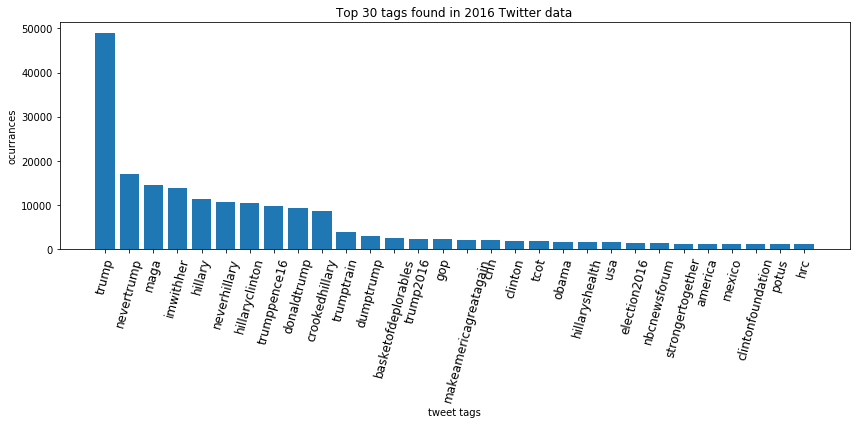

In [352]:
x = df_tags_for_counting['tags'].value_counts().head(30).index
y = df_tags_for_counting['tags'].value_counts().head(30)

fig, ax = plt.subplots(figsize=(12,6), tight_layout=True)

ax.set_title('Top 30 tags found in 2016 Twitter data')
ax.set_xlabel('tweet tags')
ax.set_ylabel('ocurrances')
ax.tick_params(axis='x', rotation=75)
plt.xticks(fontsize=12) 

plt.bar(x,y)

### Attempt to classify tweet tags based on some supervised learning

In [337]:
import nltk.classify.util
from nltk.classify import NaiveBayesClassifier

tags = df_tags_for_counting['tags']



# A function that extracts which words exist in a text based on a list of words to which we compare.
def word_feats(words):
        return dict([(word, True) for word in words])

# Get the tags presumably for candidate 1  
hillary_tags = ['hillaryclinton','hillary','nevertrump','imwithher','dumptrump', 'clinton', 'hillary2016', 'strongertogether' ]

# Get the tags presumably for candidate 2
trump_tags = ['trumppence16', 'trump2016', 'maga', 'crookedhillary', 'gop', 'makeamericagreatagain', 'neverhillary', 'hillaryshealth' ]
 
# Find the features that most correspond to hillary    
candidate_one = [(word_feats(tags), '1') for w in hillary_tags]

# Find the features that most correspond to hillary    
candidate_two = [(word_feats(tags), '2') for w in trump_tags]

# We would only use 1500 instances to train on. The quarter of the reviews left is for testing purposes.
one_cutoff = int(len(candidate_one)*0.70)
two_cutoff = int(len(candidate_two)*0.70)

In [338]:
# Construct the training dataset containing 50% positive reviews and 50% negative reviews
trainfeats = candidate_one[:one_cutoff] + candidate_two[:two_cutoff]

# Construct the negative dataset containing 50% positive reviews and 50% negative reviews
testfeats = candidate_one[one_cutoff:] + candidate_two[two_cutoff:]

print ('train on %d instances, test on %d instances' % (len(trainfeats), len(testfeats)))

# Train a NaiveBayesClassifier
classifier = NaiveBayesClassifier.train(trainfeats)

# Test the trained classifier and display the most informative features.
print ('accuracy:', nltk.classify.util.accuracy(classifier, testfeats))
classifier.show_most_informative_features()

train on 10 instances, test on 6 instances
accuracy: 0.5
Most Informative Features
               voldemort = True                2 : 1      =      1.0 : 1.0
             canonlyhope = True                2 : 1      =      1.0 : 1.0
               istrumpok = True                2 : 1      =      1.0 : 1.0
               hypnotoad = True                2 : 1      =      1.0 : 1.0
                  finsup = True                2 : 1      =      1.0 : 1.0
        arcofthecovenant = True                2 : 1      =      1.0 : 1.0
               clickbait = True                2 : 1      =      1.0 : 1.0
          trumpsurrogate = True                2 : 1      =      1.0 : 1.0
              physicians = True                2 : 1      =      1.0 : 1.0
              hrconf2016 = True                2 : 1      =      1.0 : 1.0


# Sentiment Analysis

### Using NLTK to get started

In [4]:
nltk.download('popular')

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to
[nltk_data]    |     /home/andrew/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package gazetteers to
[nltk_data]    |     /home/andrew/nltk_data...
[nltk_data]    |   Unzipping corpora/gazetteers.zip.
[nltk_data]    | Downloading package genesis to
[nltk_data]    |     /home/andrew/nltk_data...
[nltk_data]    |   Unzipping corpora/genesis.zip.
[nltk_data]    | Downloading package gutenberg to
[nltk_data]    |     /home/andrew/nltk_data...
[nltk_data]    |   Unzipping corpora/gutenberg.zip.
[nltk_data]    | Downloading package inaugural to
[nltk_data]    |     /home/andrew/nltk_data...
[nltk_data]    |   Unzipping corpora/inaugural.zip.
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /home/andrew/nltk_data...
[nltk_data]    |   Unzipping corpora/movie_reviews.zip.
[nltk_data]    | Downloading package name

True

In [392]:
# straight from the week 3/4 work college

import nltk.classify.util
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import movie_reviews


# A function that extracts which words exist in a text based on a list of words to which we compare.
def word_feats(words):
        return dict([(word, True) for word in words])

# Get the negative reviews for movies    
negids = movie_reviews.fileids('neg')

# Get the positive reviews for movies
posids = movie_reviews.fileids('pos')
 
# Find the features that most correspond to negative reviews    
negfeats = [(word_feats(movie_reviews.words(fileids=[f])), 'neg') for f in negids]

# Find the features that most correspond to positive reviews
posfeats = [(word_feats(movie_reviews.words(fileids=[f])), 'pos') for f in posids]

# We would only use 1500 instances to train on. The quarter of the reviews left is for testing purposes.
negcutoff = int(len(negfeats)*0.60)
poscutoff = int(len(posfeats)*0.60)

In [393]:
# Construct the training dataset containing 50% positive reviews and 50% negative reviews
trainfeats = negfeats[:negcutoff] + posfeats[:poscutoff]

# Construct the negative dataset containing 50% positive reviews and 50% negative reviews
testfeats = negfeats[negcutoff:] + posfeats[poscutoff:]

print ('train on %d instances, test on %d instances' % (len(trainfeats), len(testfeats)))

# Train a NaiveBayesClassifier
classifier = NaiveBayesClassifier.train(trainfeats)

# Test the trained classifier and display the most informative features.
print ('accuracy:', nltk.classify.util.accuracy(classifier, testfeats))
classifier.show_most_informative_features()

train on 1200 instances, test on 800 instances
accuracy: 0.76625
Most Informative Features
             outstanding = True              pos : neg    =     14.2 : 1.0
               stupidity = True              neg : pos    =     13.7 : 1.0
               ludicrous = True              neg : pos    =     13.7 : 1.0
              vulnerable = True              pos : neg    =     11.0 : 1.0
             uninvolving = True              neg : pos    =     11.0 : 1.0
               insulting = True              neg : pos    =     10.3 : 1.0
                   inept = True              neg : pos    =      9.8 : 1.0
                   chick = True              neg : pos    =      9.7 : 1.0
           unintentional = True              neg : pos    =      9.7 : 1.0
             beautifully = True              pos : neg    =      9.4 : 1.0


### We're going to attempt to classify the tweet text with the trained model from IMDB

In [379]:
# we need the '.head()' or the extract features method doesnt do the right thing
tweets = df_uid_text_tags[['_id','sanitized_text']].head(10000)

In [394]:
def get_words_in_tweets(text):
    all_words = []
    for words in text:
        all_words.extend(words)
    return all_words

In [395]:
# Create a dictionary measuring word frequencies
# Input: the list of words
# Output: the frequency of those words apearing in tweets
def get_word_features(wordlist):
    wordlist = nltk.FreqDist(wordlist)
    word_features = wordlist.keys()
    pprint.pprint(wordlist)
    return word_features

In [396]:
all_tweet_words = get_words_in_tweets(tweets['sanitized_text'])

In [397]:
tweet_word_features = get_word_features(all_tweet_words)

{'00': 57,
 '000': 25,
 '0000': 4,
 '00000': 3,
 '000000': 2,
 '0000000': 1,
 '00000000': 5,
 '00000000000': 8,
 '00000001': 2,
 '0000005': 1,
 '000000wonthurtabillionaire': 1,
 '000001': 1,
 '00001': 1,
 '0001': 2,
 '0001shouldnt': 1,
 '0003': 1,
 '0004': 1,
 '0005': 1,
 '000666': 1,
 '0007': 1,
 '0009': 2,
 '000emails': 3,
 '000in': 5382,
 '000s': 1,
 '001': 5,
 '00101100100': 1,
 '00110111001': 1,
 '00147479804': 2,
 '002': 5,
 '0023': 1,
 '0024': 2,
 '003': 3,
 '004': 1,
 '0048': 1,
 '0049': 2,
 '004in': 123,
 '005': 4,
 '005in': 13,
 '006': 1,
 '0064': 16,
 '007': 7,
 '008': 2,
 '008in': 45,
 '009': 2,
 '00905364638': 1,
 '00923029426': 1,
 '009in': 9,
 '00clnt': 1,
 '00communismiran': 1,
 '00m': 1,
 '00mph': 4001,
 '00nysuck': 1,
 '00px': 1,
 '00rah': 1,
 '01': 32,
 '010': 4,
 '0103': 1,
 '0104': 1,
 '010416': 1,
 '0107who': 1,
 '0109': 2,
 '010916': 2,
 '012': 2,
 '012016': 2,
 '012017': 1,
 '0125': 1,
 '0128': 1,
 '0129': 1,
 '012in': 82,
 '013in': 13,
 '0149': 1,
 '01490013': 

 '1com': 4,
 '1comment': 1,
 '1community': 1,
 '1cor': 1,
 '1cor6': 1,
 '1corinthians': 1,
 '1corinthians155': 1,
 '1corinthians1551': 1,
 '1crook': 1,
 '1d': 3,
 '1daughter': 1,
 '1day': 9,
 '1dayrests': 1,
 '1daywk': 1,
 '1debate': 1,
 '1democrat': 1,
 '1dems': 2,
 '1deport': 1,
 '1der': 1,
 '1dialogue': 2,
 '1donald': 1,
 '1doubt': 1,
 '1ear': 1,
 '1econ': 1,
 '1economy2immigration3lawamporder4vetsampmilitary': 1,
 '1else': 3,
 '1elsegoing2': 1,
 '1emails': 1,
 '1ence': 1,
 '1end': 1,
 '1enforce': 1,
 '1er': 15,
 '1era': 1,
 '1eras': 1,
 '1ero': 3,
 '1eros': 1,
 '1ers': 13,
 '1ersdoesnt': 1,
 '1eurohr': 1,
 '1even': 1,
 '1few': 1,
 '1finger': 1,
 '1fraud': 1,
 '1fucking': 1,
 '1get': 2,
 '1gf': 1,
 '1gfvgc': 1,
 '1go': 1,
 '1gop': 1,
 '1group': 2,
 '1gthis': 1,
 '1h1': 1,
 '1h13': 1,
 '1has': 1,
 '1hates': 1,
 '1having': 1,
 '1he': 3,
 '1hellofaspeach2americaonwhatmrtrumpis': 1,
 '1helps': 1,
 '1her': 1,
 '1hes': 1,
 '1hopedjt': 1,
 '1hour': 4,
 '1hr': 11,
 '1i': 1,
 '1in': 1,
 '1in

 '2negotiate': 1,
 '2nevertrump': 1,
 '2new': 1,
 '2news': 1,
 '2night': 14,
 '2nights': 1,
 '2nit': 1,
 '2nite': 45,
 '2nite2': 1,
 '2nitebetter': 1,
 '2nitedumb': 1,
 '2nites': 2,
 '2nj': 1,
 '2nly': 1,
 '2no': 8,
 '2nogood4ourcountryampheshelpingletshelpampvote': 1,
 '2none': 1,
 '2normal': 1,
 '2normalize': 1,
 '2not': 7,
 '2notice': 1,
 '2noticehis': 1,
 '2now': 2,
 '2nt': 1,
 '2nte': 3,
 '2nuke': 1,
 '2nuns': 1,
 '2nxt': 1,
 '2ny': 1,
 '2o': 5,
 '2o16': 3,
 '2obama': 4,
 '2obey': 1,
 '2occur': 1,
 '2of': 3,
 '2of2': 10,
 '2of2likely': 1,
 '2ofdozens2sue4defamationof': 1,
 '2offend': 1,
 '2offer': 2,
 '2officers': 15,
 '2offset': 1,
 '2ofoodbleach': 1,
 '2often2': 1,
 '2ofu': 1,
 '2ogt': 1,
 '2one': 2,
 '2only': 1,
 '2oo': 1,
 '2ook': 1,
 '2operatevs': 1,
 '2oppose': 1,
 '2opposecondem': 1,
 '2oppressed': 1,
 '2or3': 1,
 '2orchestrate': 1,
 '2other': 2,
 '2our': 10,
 '2ourstatenlamedia': 1,
 '2out': 1,
 '2overcome': 1,
 '2overflow': 1,
 '2overide': 1,
 '2overrde': 1,
 '2override':

 '4hrc': 7,
 '4hrdeports': 1,
 '4hrpolish': 1,
 '4hrs': 3,
 '4hs': 2,
 '4humor': 1,
 '4husband': 2,
 '4illegals': 3,
 '4illegalsdreamers': 1,
 '4immigrants': 1,
 '4immigration': 1,
 '4indefinite': 1,
 '4info': 2,
 '4ing': 1,
 '4insidescoops': 1,
 '4instance': 1,
 '4insulting': 1,
 '4insultingamericans': 1,
 '4investigations4': 1,
 '4iran': 4,
 '4iraq': 3,
 '4iraqgt2003400mil': 1,
 '4iraqinvasion': 1,
 '4is': 1,
 '4isis': 1,
 '4it': 10,
 '4itand': 1,
 '4itselfreply': 1,
 '4itthe': 1,
 '4ivote4the1whobuiltafoundationoflove': 1,
 '4jail': 1,
 '4jillstein': 1,
 '4jim': 1,
 '4job': 2,
 '4jobs': 1,
 '4joy': 1,
 '4justice': 1,
 '4k': 15,
 '4kkk': 1,
 '4kkkrally': 1,
 '4kremlin': 1,
 '4lack': 1,
 '4ladys': 1,
 '4lastampdestroy': 1,
 '4lawamporder': 2,
 '4leaving': 1,
 '4left': 1,
 '4less': 1,
 '4letter': 2,
 '4liar4hireracisttrump': 1,
 '4liars': 1,
 '4lies': 1,
 '4liestreason': 1,
 '4life': 3,
 '4lifequestn': 2,
 '4lights': 1,
 '4links': 1,
 '4longthx': 1,
 '4louisiana': 1,
 '4louisianavictim

 '850k': 1,
 '8515': 1,
 '85255': 7,
 '85361voters': 1,
 '8548234123': 1,
 '8551936': 1,
 '8590': 1,
 '85day': 1,
 '85iq': 1,
 '85k': 2,
 '85mexicanos': 1,
 '85mph': 1,
 '85th': 1,
 '85x11': 1,
 '86': 26,
 '86000': 2,
 '8605664840': 1,
 '8616': 1,
 '863': 1,
 '865m': 1,
 '866594hope': 1,
 '866594hope4673': 1,
 '8666106397': 7,
 '867': 1,
 '8690': 1,
 '8691': 1,
 '86antidrug': 2,
 '86days': 1,
 '86dayshe': 1,
 '86k': 2,
 '86million': 1,
 '86thats': 1,
 '86yearsold': 1,
 '86yo': 1,
 '87': 41,
 '8700': 1,
 '8713811188': 1,
 '8716': 5,
 '872': 1,
 '873': 1,
 '875': 3,
 '876': 2,
 '877877': 10,
 '878': 4,
 '87art': 1,
 '87th': 1,
 '88': 176,
 '8800': 1,
 '88000': 2,
 '88075': 1,
 '8811': 1,
 '8812': 1,
 '883': 1,
 '885': 1,
 '8863': 1,
 '887': 2,
 '888': 5,
 '8894': 1,
 '88days': 1,
 '88yo': 1,
 '89': 33,
 '890': 1,
 '89000': 1,
 '89052': 1,
 '8919': 1,
 '892': 2,
 '8930000': 1,
 '895': 1,
 '897': 1,
 '8991': 1,
 '89ez98tsz': 1,
 '89how': 1,
 '89pct': 1,
 '89yrold': 1,
 '8a': 1,
 '8am': 11,

 'actg': 1,
 'acthe': 1,
 'acthes': 1,
 'acthil': 1,
 'acthis': 1,
 'acti': 1,
 'actially': 1,
 'actin': 2,
 'acting': 454,
 'actingpresid': 11,
 'actingpresidpence': 12,
 'action': 1241,
 'actionable': 4,
 'actionand': 1,
 'actionbut': 1,
 'actiondo': 1,
 'actionif': 1,
 'actionimpeach': 2,
 'actionmove': 1,
 'actionno': 1,
 'actionplease': 1,
 'actionremember': 1,
 'actionresults': 24,
 'actionréaction': 1,
 'actions': 4,
 'actionsand': 1,
 'actionsbad': 1,
 'actionsby': 1,
 'actionsher': 1,
 'actionshes': 2,
 'actionsinaction': 1,
 'actionsit': 1,
 'actionsliesrot': 1,
 'actionsneed': 1,
 'actionsnon': 1,
 'actionsnotwords': 1,
 'actionsolutions': 29,
 'actionspeaks': 1,
 'actionsreport': 1,
 'actionsthe': 2,
 'actionsthus': 1,
 'actionswe': 2,
 'actionswhether': 1,
 'actionswords': 2,
 'actionthis': 1,
 'actionwere': 1,
 'actit': 1,
 'actitud': 10,
 'activamentevienen': 1,
 'activas': 2,
 'activate': 11,
 'activated': 11,
 'activates': 1,
 'activation': 2,
 'active': 152,
 'activea

 'ahoudl': 1,
 'ahould': 1,
 'ahoy': 1,
 'ahplaydough': 1,
 'ahre': 1,
 'ahs': 7,
 'ahscruzgramkishj': 1,
 'ahshahah': 1,
 'ahso': 1,
 'ahsure': 1,
 'aht': 1,
 'ahthe': 1,
 'ahuevo': 2,
 'ahum': 1,
 'ahurry': 2,
 'ahvery': 1,
 'ahá': 1,
 'ahí': 46,
 'ai': 23,
 'aiaska': 1,
 'aick': 1,
 'aiction': 1,
 'aid': 512,
 'aidabet': 1,
 'aidampabet': 1,
 'aidan': 1,
 'aidant': 1,
 'aidapix': 1,
 'aide': 400,
 'aided': 23,
 'aideepipen': 1,
 'aidehuma': 1,
 'aiden': 4,
 'aiders': 1,
 'aides': 1,
 'aidesalso': 1,
 'aidesassistants': 1,
 'aidfunding': 1,
 'aidi': 1,
 'aiding': 38,
 'aidingterrorists': 1,
 'aidsfighting': 1,
 'aidshe': 1,
 'aidsother': 1,
 'aidswhereprove': 1,
 'aidtravels': 1,
 'aiga': 2,
 'aight': 2,
 'aiguële': 1,
 'aije': 1,
 'aikaan': 1,
 'ail': 14,
 'aile': 1,
 'ailed': 2,
 'ailes': 404,
 'ailesif': 1,
 'ailesperversely': 1,
 'ailesrun': 1,
 'ailessexual': 1,
 'ailesso': 1,
 'ailing': 9,
 'ailles': 2,
 'ailment': 17,
 'ailmentsget': 1,
 'ailorsare': 1,
 'aim': 45,
 'aima': 1,

 'americansthen': 1,
 'americansthey': 3,
 'americansthis': 1,
 'americansto': 1,
 'americanstrump': 2,
 'americanstry': 1,
 'americanstyledemocracy': 1,
 'americansu': 4,
 'americansuch': 1,
 'americansvote': 2,
 'americansvotes': 1,
 'americansvoting': 1,
 'americanswake': 1,
 'americanswe': 2,
 'americanswhat': 4,
 'americanswhile': 1,
 'americanswhoa': 1,
 'americanswholosttheir': 1,
 'americanswomenasians': 1,
 'americanswomenmuslims': 1,
 'americansyou': 2,
 'americanthat': 1,
 'americantotal': 1,
 'americantraitors': 1,
 'americantrump': 1,
 'americanu': 1,
 'americanwe': 2,
 'americanwho': 1,
 'americanwill': 1,
 'americanyou': 1,
 'americanyour': 1,
 'americaobama': 3,
 'americaok': 1,
 'americaone': 1,
 'americaonly': 1,
 'americapatriotsveterans': 1,
 'americapay': 1,
 'americaplease': 1,
 'americapleasedont': 1,
 'americapraying': 1,
 'americapre': 1,
 'americareally': 1,
 'americareallyever': 1,
 'americareserch': 1,
 'americasad': 1,
 'americasampworlds': 1,
 'americasaud

 'andanada': 1,
 'andar': 7,
 'andas': 21,
 'andate': 1,
 'andato': 2,
 'andbbynm': 1,
 'andbetter': 1,
 'andboth': 1,
 'andcant': 1,
 'andchief': 1,
 'andchurches': 1,
 'andcmon': 1,
 'andcountry': 1,
 'andcrickets': 1,
 'andcriminalproblems': 1,
 'andddd': 2,
 'anddddd': 1,
 'anddivorce': 1,
 'anddo': 1,
 'ande': 2,
 'andea': 1,
 'andel': 1,
 'andele': 1,
 'anden': 1,
 'andera': 3,
 'andere': 1,
 'anderen': 1,
 'anderes': 1,
 'anders': 5,
 'andersen': 2,
 'andersenafb': 1,
 'anderson': 119,
 'andersoncoop': 1,
 'andersoncooper': 1,
 'andersoncoopers': 1,
 'andersoni': 1,
 'andersonville': 1,
 'andes': 2,
 'andfor': 1,
 'andgeeethey': 1,
 'andgo': 1,
 'andgotcaughttakingwh': 1,
 'andgut': 1,
 'andhad': 1,
 'andhatred': 1,
 'andhe': 4,
 'andhes': 1,
 'andhiding': 1,
 'andhillarophobic': 1,
 'andhillarysbehaviorscloser': 1,
 'andhis': 2,
 'andhood': 1,
 'andhow': 2,
 'andhowmanytimesareyouallgoing': 1,
 'andi': 2,
 'andiamo': 1,
 'andie': 1,
 'andif': 1,
 'andim': 1,
 'andin': 1,
 'andi

 'appnt': 1,
 'appoint': 105,
 'appointed': 56,
 'appointee': 17,
 'appointing': 19,
 'appointment': 74,
 'appointments': 1,
 'appointmentsmaybe': 1,
 'appointmentsseriously': 1,
 'appointmentsthis': 1,
 'appoints': 17,
 'appolicze': 1,
 'appolizized': 2,
 'appologize': 9,
 'appologized': 4,
 'appology': 1,
 'apponent': 2,
 'appontiment': 1,
 'apportioned': 1,
 'appose': 1,
 'apposed': 1,
 'appositely': 1,
 'appplause': 1,
 'appr': 2,
 'apprach': 1,
 'appraisal': 2,
 'appraiser': 1,
 'appraoch': 1,
 'apprciate': 1,
 'appreance': 1,
 'apprec': 1,
 'appreci': 1,
 'appreciate': 249,
 'appreciated': 46,
 'appreciateda': 1,
 'appreciatedoh': 1,
 'appreciatedyour': 1,
 'appreciates': 23,
 'appreciating': 6,
 'appreciation': 28,
 'appreciative': 9,
 'apprecilove': 1,
 'apprehend': 1,
 'apprehended': 3,
 'apprehending': 1,
 'apprehensionshe': 1,
 'apprentice': 143,
 'apprenticed': 1,
 'apprenticeexplains': 1,
 'apprenticehe': 1,
 'apprenticehoneybooboo': 1,
 'apprenticejakesullivanfrmnatsecadv

 'ataques': 10,
 'atar': 1,
 'atarım': 2,
 'atasket': 1,
 'atau': 1,
 'atavistic': 2,
 'atañe': 1,
 'ataúd': 4,
 'atbout': 1,
 'atcha': 2,
 'atchshes': 1,
 'atckd': 1,
 'atconspiracy': 1,
 'ate': 97,
 'ateady': 1,
 'ateam': 7,
 'ateleprompter': 1,
 'atem': 1,
 'atempt': 1,
 'atena': 1,
 'atencion': 4,
 'atención': 17,
 'atender': 6,
 'atenderá': 1,
 'atendió': 1,
 'atenta': 3,
 'atentado': 4,
 'atentan': 1,
 'atento': 3,
 'atentos': 2,
 'atents': 1,
 'ater': 2,
 'aterrado': 1,
 'aterrador': 4,
 'aterriza': 2,
 'aterrizado': 2,
 'aterrizar': 2,
 'aterrizó': 1,
 'atf': 3,
 'atfake': 1,
 'ath': 1,
 'athe': 1,
 'atheism': 3,
 'atheist': 64,
 'athelete': 1,
 'athem': 2,
 'athens': 5,
 'athensbrexitberlin': 2,
 'athensso': 1,
 'ather': 1,
 'athey': 1,
 'atheyre': 1,
 'athiest': 2,
 'athiests': 1,
 'athillaryclinton': 1,
 'athing': 1,
 'athis': 1,
 'athlete': 124,
 'athletic': 8,
 'athletically': 1,
 'athletics': 2,
 'athng': 1,
 'athon': 1,
 'athorities': 1,
 'athorough': 1,
 'athunk': 1,
 '

 'baggie': 1,
 'baggin': 1,
 'bagging': 4,
 'baggy': 5,
 'baghdad': 17,
 'baghdadi': 8,
 'baghdadis': 1,
 'baghdadkuwait': 1,
 'bagman': 2,
 'bagmight': 1,
 'bags': 1,
 'bagscorruptrundeep': 1,
 'bagslast': 1,
 'bagsmove': 1,
 'bagsservingusinsteadofbeingpotus': 1,
 'bagthats': 1,
 'bagthe': 1,
 'bagthrew': 1,
 'bagwhat': 1,
 'bagwhy': 1,
 'bagwoman': 1,
 'bah': 11,
 'baha': 3,
 'bahaa': 1,
 'bahaaaa': 2,
 'bahaaahhaaahahaha': 1,
 'bahaha': 17,
 'bahahah': 1,
 'bahahaha': 21,
 'bahahahah': 1,
 'bahahahaha': 20,
 'bahahahahaaa': 1,
 'bahahahahaamp': 1,
 'bahahahahah': 1,
 'bahahahahaha': 8,
 'bahahahahahaha': 4,
 'bahahahahahahaha': 1,
 'bahahahahahahahaha': 1,
 'bahahahahha': 1,
 'bahahahhaahahaha': 1,
 'bahahbahaaa': 1,
 'bahahha': 1,
 'bahahhaa': 1,
 'bahahhaaha': 1,
 'bahamas': 2,
 'bahara': 2,
 'bahbah': 1,
 'bahha': 1,
 'bahhh': 3,
 'bahrain': 19,
 'bahsedeceğim': 1,
 'bai': 1,
 'baia': 4,
 'baier': 4,
 'baierampkellyhas': 1,
 'baiers': 1,
 'bail': 66,
 'baila': 1,
 'bailar': 2,
 

 'befuddling': 1,
 'befunny': 1,
 'beg': 137,
 'begahzi': 1,
 'begain': 1,
 'begala': 8,
 'begalla': 1,
 'began': 116,
 'beganget': 5,
 'begas': 1,
 'begat': 3,
 'begats': 2,
 'begeeft': 1,
 'begeezus': 1,
 'beget': 2,
 'begets': 11,
 'beggar': 9,
 'begged': 25,
 'begger': 1,
 'beggers': 1,
 'beggin': 2,
 'begging': 176,
 'beggining': 2,
 'beghazi': 1,
 'beghazithing': 1,
 'begin': 485,
 'beginbut': 1,
 'beging': 2,
 'begining': 1,
 'beginit': 1,
 'beginlong': 1,
 'beginlove': 1,
 'beginn': 1,
 'beginner': 3,
 'beginning': 397,
 'beginningget': 1,
 'beginninghopefully': 1,
 'beginningimagine': 1,
 'beginningkarma': 1,
 'beginningkeep': 1,
 'beginningmacys': 1,
 'beginningpics': 1,
 'beginningsome': 1,
 'beginningwe': 2,
 'beginsagain': 1,
 'beginsid': 1,
 'beginslets': 1,
 'beginsthank': 1,
 'begint': 1,
 'begn': 2,
 'begone': 8,
 'begot': 1,
 'begotten': 1,
 'begrijp': 2,
 'begrip': 1,
 'begrudgingly': 3,
 'begründer': 1,
 'begs': 38,
 'beguile': 2,
 'beguiled': 2,
 'begun': 54,
 'beg

 'bigotsracistssexistsself': 1,
 'bigotstick': 1,
 'bigotsto': 1,
 'bigotsuneducated': 1,
 'bigotswe': 1,
 'bigotswhat': 1,
 'bigotswhite': 1,
 'bigotsyou': 1,
 'bigott': 1,
 'bigotted': 6,
 'bigotthank': 1,
 'bigotthat': 2,
 'bigotthis': 1,
 'bigottrue': 1,
 'bigottruly': 1,
 'bigotwhere': 1,
 'bigoty': 1,
 'bigotyet': 1,
 'bigotyou': 1,
 'bigotyour': 1,
 'bigpayday': 1,
 'bigpayments': 4,
 'bigpaymets': 1,
 'bigpenis': 1,
 'bigrancidsmelly': 1,
 'bigs': 4,
 'bigsby': 1,
 'bigsbys': 1,
 'bigshot': 2,
 'bigso': 1,
 'bigstaffed': 1,
 'bigstory': 1,
 'bigsupporter': 1,
 'bigt': 1,
 'bigthat': 1,
 'bigthe': 1,
 'bigtime': 14,
 'bigtimenot': 1,
 'bigummmmmsince': 1,
 'bigun': 1,
 'bigut': 1,
 'bigvery': 2,
 'bigwig': 3,
 'bigwood': 1,
 'bih': 5,
 'bihh': 1,
 'bii': 1,
 'biiih': 1,
 'biiiiiiiiiig': 1,
 'biil': 1,
 'bij': 8,
 'bijan': 1,
 'bijzondere': 1,
 'bike': 28,
 'bikeathon': 1,
 'bikebut': 1,
 'biked': 1,
 'biker': 14,
 'bikers': 38,
 'bikersamerican': 1,
 'bikersgt': 1,
 'bikerspleas

 'bonifide': 2,
 'boning': 2,
 'bonita': 5,
 'bonitas': 2,
 'bonitass': 1,
 'bonito': 6,
 'bonjovi': 3,
 'bonkers': 29,
 'bonkerswtf': 1,
 'bonne': 11,
 'bonner': 1,
 'bonnet': 2,
 'bonni': 1,
 'bonnie': 47,
 'bonnieamp': 1,
 'bonnieampclydehardscrambledrealitylifeonroad': 1,
 'bonniei': 1,
 'bonnor': 1,
 'bonny': 2,
 'bono': 10,
 'bons': 3,
 'bonsai': 2,
 'bonsi': 1,
 'bonsoir': 1,
 'bont': 1,
 'bonus': 36,
 'bonzo': 1,
 'boo': 213,
 'boob': 46,
 'boobala': 1,
 'boobapollsa': 1,
 'boobass': 1,
 'boobay': 1,
 'booblike': 1,
 'booboo': 3,
 'booby': 5,
 'boobytrap': 1,
 'boobytrapped': 1,
 'boobytraps': 2,
 'bood': 4,
 'boodtie': 1,
 'booed': 30,
 'booedlooks': 1,
 'booedloudly': 1,
 'booey': 1,
 'boofs': 1,
 'booga': 2,
 'boogaloo': 1,
 'booger': 6,
 'boogey': 1,
 'boogeyman': 8,
 'boogie': 17,
 'boogieman': 1,
 'boogy': 1,
 'boohoo': 20,
 'boohooboohoo': 1,
 'booii': 1,
 'booing': 8,
 'book': 1310,
 'bookbad': 1,
 'bookbought': 1,
 'bookbravo': 1,
 'bookcase': 1,
 'bookclinton': 1,
 'b

 'brokestop': 2,
 'brokew': 1,
 'broking': 1,
 'broll': 2,
 'broma': 18,
 'bromamayuppers': 1,
 'bromance': 73,
 'bromancewithputin': 1,
 'bromeó': 1,
 'bromide': 1,
 'bromista': 1,
 'bron': 2,
 'bronca': 4,
 'broncas': 2,
 'bronceado': 2,
 'bronchitis': 7,
 'bronchoscopy': 1,
 'bronco': 3,
 'broncofisch': 1,
 'bronconón': 1,
 'bronson': 5,
 'bronx': 11,
 'bronxville': 1,
 'bronzage': 1,
 'bronze': 11,
 'bronzer': 3,
 'bronzeville': 1,
 'brood': 6,
 'brook': 28,
 'brooke': 13,
 'brooker': 2,
 'brooklyn': 55,
 'brooklynhrc': 1,
 'brookpark': 3,
 'brookyn': 1,
 'broom': 35,
 'broomstick': 10,
 'brorther': 1,
 'bros': 43,
 'brosin': 1,
 'broth': 4,
 'brotha': 16,
 'brothas': 3,
 'brothel': 8,
 'brother': 582,
 'brothera': 1,
 'brotherall': 1,
 'brotheramp': 1,
 'brotherampsister': 1,
 'brotherand': 1,
 'brotherask': 1,
 'brotherfind': 1,
 'brotherhd': 1,
 'brotherhe': 1,
 'brotherhood': 181,
 'brotherhoodin': 1,
 'brotherhoodmuslim': 1,
 'brotherhoodterrorist': 1,
 'brotherhoodthey': 1,
 

 'bytemi': 1,
 'bythanksthe': 1,
 'bythe': 1,
 'bytrump': 2,
 'bytrumps': 1,
 'byu': 2,
 'byva': 1,
 'byvthus': 1,
 'byw': 2,
 'bywait': 1,
 'bywhom': 1,
 'byyou': 1,
 'byyour': 1,
 'byyyyyeeeee': 1,
 'bz': 6,
 'bzzz': 1,
 'bzzzt': 1,
 'b²': 1,
 'bárbaro': 1,
 'bárbaros': 1,
 'básicamente': 2,
 'básquet': 1,
 'bâtir': 1,
 'bär': 1,
 'bästa': 4,
 'bättre': 1,
 'bé': 1,
 'bélica': 1,
 'bénisse': 1,
 'bénéfice': 4,
 'bénéficiaires': 1,
 'bénéficier': 1,
 'bête': 1,
 'bíblico': 2,
 'bölgeye': 1,
 'börjar': 1,
 'börjat': 1,
 'böyle': 1,
 'bütçe': 1,
 'bütün': 4,
 'büyük': 2,
 'bývproruské': 1,
 'bě': 1,
 'bıktık': 1,
 'bırak': 1,
 'bㄷ': 1,
 'c1': 1,
 'c10': 1,
 'c130s': 2,
 'c17': 1,
 'c17s': 1,
 'c2nd': 1,
 'c3': 1,
 'c37916': 1,
 'c3cm': 1,
 'c3po': 1,
 'c4': 3,
 'c5': 3,
 'c6': 2,
 'c7': 4,
 'c8': 1,
 'c88': 1,
 'c89': 1,
 'c9': 1,
 'ca': 242,
 'ca77': 1,
 'caaaaaaaant': 1,
 'caaaaaant': 1,
 'caae': 1,
 'caall': 1,
 'cab': 14,
 'cabal': 37,
 'caball': 1,
 'caballero': 7,
 'caballeros': 1

 'cassius': 2,
 'cassus': 1,
 'cast': 191,
 'casta': 2,
 'castamp': 1,
 'castampcrew': 1,
 'castanza': 1,
 'caste': 6,
 'casted': 1,
 'castellanos': 1,
 'caster': 4,
 'castigado': 1,
 'castigará': 1,
 'castigate': 1,
 'castigated': 1,
 'castigates': 2,
 'castigating': 1,
 'castigation': 1,
 'castigo': 1,
 'castile': 1,
 'casting': 51,
 'castitate': 1,
 'castle': 22,
 'castlevanias': 1,
 'castor': 1,
 'castraited': 1,
 'castrarlos': 1,
 'castrate': 8,
 'castrated': 8,
 'castratedcome': 1,
 'castrating': 1,
 'castration': 3,
 'castrista': 1,
 'castro': 66,
 'castroadulones': 1,
 'castrobros': 1,
 'castrochavistas': 1,
 'castrofarcsantos': 7,
 'castrofarcsantps': 1,
 'casual': 22,
 'casualidad': 1,
 'casually': 6,
 'casualty': 26,
 'casuela': 1,
 'cat': 292,
 'cataclysm': 1,
 'cataclysmic': 1,
 'catagories': 1,
 'catalina': 2,
 'catalizado': 1,
 'catalog': 3,
 'cataloged': 1,
 'catalogue': 3,
 'catalogued': 1,
 'catalogó': 2,
 'cataluña': 1,
 'catalyst': 11,
 'catalytic': 1,
 'catanese': 

 'cheiek': 1,
 'cheif': 7,
 'chek': 2,
 'cheks': 1,
 'chela': 1,
 'chels': 1,
 'chelsa': 1,
 'chelsea': 282,
 'chelseaamphusband': 1,
 'chelseadebbiewe': 1,
 'chelseado': 1,
 'chelseaegypts': 2,
 'chelseahillarynastybilldaddygrandpa': 1,
 'chelseas': 111,
 'chelseathank': 1,
 'chelseawatchbillget': 1,
 'chelseawill': 1,
 'chelsey': 1,
 'chelsia': 1,
 'chelsie': 5,
 'chelsies': 1,
 'chelsy': 2,
 'chem': 6,
 'chemampbio': 1,
 'chemical': 44,
 'chemically': 1,
 'chemicalwarfare': 1,
 'chemist': 3,
 'chemistry': 5,
 'chemo': 8,
 'chemotherapy': 3,
 'chemtrails': 5,
 'chemweapons': 1,
 'chenero': 1,
 'cheney': 73,
 'cheneybush': 1,
 'cheneybushrumsfeldwoo': 1,
 'cheneydick': 1,
 'cheneys': 2,
 'chenney': 3,
 'chenny': 1,
 'cheno': 1,
 'chente': 5,
 'chep': 1,
 'cheque': 11,
 'chequea': 1,
 'chequen': 1,
 'cher': 148,
 'cherade': 1,
 'cherch': 1,
 'chercher': 1,
 'cherdo': 1,
 'cheri': 1,
 'cherie': 1,
 'cherise': 1,
 'cherish': 8,
 'cherished': 12,
 'cherishes': 4,
 'chernobyl': 1,
 'cherok

 'cliftfits': 1,
 'clifton': 2,
 'clik': 1,
 'clima': 1,
 'climactic': 1,
 'climate': 250,
 'climatechange': 2,
 'climategoodbadhe': 1,
 'climatehealthcaresocial': 1,
 'climatereality': 1,
 'climateso': 1,
 'climatevs': 1,
 'climax': 3,
 'climb': 114,
 'climbed': 11,
 'climber': 8,
 'climbershe': 1,
 'climbing': 44,
 'climbng': 1,
 'climchnghaox': 1,
 'clime': 1,
 'climton': 3,
 'climático': 3,
 'clin': 4,
 'clinch': 2,
 'clinched': 3,
 'clindent': 1,
 'cline': 1,
 'clinfound': 2,
 'clinfoundwho': 1,
 'cling': 10,
 'clingers': 2,
 'clinging': 18,
 'clingon': 6,
 'clingons': 1,
 'clingtons': 1,
 'clingy': 2,
 'clinic': 34,
 'clinical': 6,
 'clinically': 17,
 'clinician': 2,
 'clink': 1,
 'clint': 44,
 'clintama': 1,
 'clintbama': 1,
 'clinteone': 1,
 'clinternet': 1,
 'clintin': 2,
 'clintinpot': 1,
 'clintion': 4,
 'clintions': 3,
 'clinto': 4,
 'clinton': 15711,
 'clintona': 4,
 'clintonall': 1,
 'clintonamp': 2,
 'clintonampfriends': 1,
 'clintonamploretta': 1,
 'clintonampobama': 2,

 'comfortable': 131,
 'comfortablelike': 1,
 'comfortablet': 1,
 'comfortably': 13,
 'comfortact': 1,
 'comforted': 6,
 'comforter': 1,
 'comforting': 19,
 'comfortinghed': 1,
 'comforton': 1,
 'comfotably': 1,
 'comfy': 16,
 'comfywhats': 1,
 'comg': 1,
 'comgress': 1,
 'comhrats': 1,
 'comi': 2,
 'comic': 59,
 'comical': 75,
 'comically': 7,
 'comicalthey': 1,
 'comiccon': 1,
 'comicios': 2,
 'comicon': 1,
 'comicsgeez': 1,
 'comida': 2,
 'comidian': 1,
 'comido': 2,
 'comie': 2,
 'comiendo': 1,
 'comienza': 12,
 'comienzan': 2,
 'comillas': 4,
 'comimg': 1,
 'comin': 35,
 'cominciare': 1,
 'comined': 1,
 'coming': 2715,
 'comingagain': 1,
 'comingampeveryone': 1,
 'comingfrom': 3,
 'cominggt': 2,
 'cominggtthose': 1,
 'comingi': 2,
 'comingled': 2,
 'comingling': 1,
 'cominglol': 1,
 'comingthats': 1,
 'comingup': 1,
 'comingwhen': 1,
 'comingwow': 1,
 'comis': 1,
 'comisionado': 1,
 'comit': 1,
 'comitato': 1,
 'comitatusact': 1,
 'comiting': 1,
 'comitted': 2,
 'comittee': 1,
 'co

 'consp': 3,
 'conspicuous': 1,
 'conspicuously': 3,
 'conspirac': 1,
 'conspiraciesgossip': 1,
 'conspiraciesheres': 1,
 'conspiraciesis': 1,
 'conspiraciesracismhateful': 2,
 'conspiracist': 1,
 'conspiracists': 1,
 'conspiración': 1,
 'conspiracy': 781,
 'conspiracyand': 1,
 'conspiracybs': 1,
 'conspiracygasm': 1,
 'conspiracyhillarywhen': 1,
 'conspiracylike': 1,
 'conspiracyminded': 1,
 'conspiracyobsessed': 3,
 'conspiracypersonal': 1,
 'conspiracysure': 1,
 'conspiracytheory': 1,
 'conspirator': 11,
 'conspiratorial': 6,
 'conspiratorious': 1,
 'conspiratòries': 1,
 'conspire': 8,
 'conspired': 13,
 'conspires': 1,
 'conspiricies': 1,
 'conspiring': 18,
 'conspiritist': 1,
 'conspriacy': 1,
 'consquences': 1,
 'consrv': 2,
 'consrvatv': 1,
 'consrvitivsnevertrumpers': 1,
 'const': 19,
 'consta': 1,
 'constance': 2,
 'constancy': 2,
 'constant': 182,
 'constante': 2,
 'constantes': 1,
 'constantly': 304,
 'constantlynow': 1,
 'constantlywhy': 1,
 'constantlyyour': 1,
 'constanza

 'corteggiato': 1,
 'corteja': 2,
 'cortes': 16,
 'cortesía': 7,
 'cortez': 7,
 'cortina': 11,
 'cortinota': 1,
 'cortito': 1,
 'cortney': 1,
 'corto': 3,
 'cortos': 2,
 'cortés': 4,
 'cortísima': 1,
 'cortó': 1,
 'corule': 1,
 'corunna': 1,
 'corunning': 1,
 'corupt': 18,
 'coruption': 10,
 'coruptos': 1,
 'coruscating': 1,
 'coruupted': 1,
 'corvette': 6,
 'cory': 35,
 'corycnn': 1,
 'coryis': 1,
 'corysad': 1,
 'corytrump': 1,
 'corée': 1,
 'cosa': 35,
 'cosas': 71,
 'cosblgs': 44,
 'cosby': 27,
 'coscorrón': 1,
 'cose': 1,
 'cosecha': 1,
 'cosell': 1,
 'coselldown': 1,
 'cosh': 1,
 'cosi': 2,
 'cosidering': 1,
 'cosign': 8,
 'cosigning': 2,
 'cosistancy': 1,
 'cosita': 1,
 'cosmetic': 5,
 'cosmic': 3,
 'cosmo': 2,
 'cosmos': 3,
 'cosmotologist': 1,
 'coso': 1,
 'cosplay': 2,
 'cossssst': 1,
 'cost': 814,
 'costa': 20,
 'costanzas': 1,
 'costar': 1,
 'costara': 1,
 'costarring': 2,
 'costará': 1,
 'costaud': 1,
 'costco': 7,
 'costcosized': 1,
 'costcutters': 1,
 'costed': 2,
 'cost

 'cruiser': 2,
 'cruisin': 2,
 'cruising': 7,
 'crule': 1,
 'crum': 1,
 'crumb': 12,
 'crumble': 24,
 'crumbled': 5,
 'crumbles': 10,
 'crumblin': 1,
 'crumbling': 50,
 'crumblng': 1,
 'crumbs': 1,
 'crummy': 3,
 'crumpet': 2,
 'crumple': 1,
 'crumpled': 1,
 'crunch': 12,
 'crunched': 1,
 'cruncher': 2,
 'crunchies': 1,
 'crunching': 3,
 'crunchtime': 1,
 'crupt': 3,
 'crusade': 20,
 'crusader': 4,
 'crusadestrumps': 1,
 'crusading': 1,
 'crush': 212,
 'crushed': 105,
 'crushin': 2,
 'crushing': 74,
 'crushong': 1,
 'crushwe': 1,
 'crust': 4,
 'crustacean': 1,
 'crusty': 16,
 'crustyo': 1,
 'crutch': 12,
 'cruuuuise': 1,
 'crux': 6,
 'cruz': 465,
 'cruza': 1,
 'cruzados': 1,
 'cruzamos': 1,
 'cruzan': 3,
 'cruzand': 2,
 'cruzando': 2,
 'cruzar': 2,
 'cruzaron': 1,
 'cruzbot': 1,
 'cruzbots': 3,
 'cruzconstituion': 1,
 'cruzcrew': 1,
 'cruzdont': 1,
 'cruze': 1,
 'cruzer': 1,
 'cruzers': 6,
 'cruzes': 1,
 'cruzhis': 1,
 'cruzies': 1,
 'cruzkasich': 2,
 'cruzkasick': 1,
 'cruzless': 2,
 

 'dealingsdebt': 1,
 'dealingsya': 1,
 'dealingwithwomeninamerica': 1,
 'dealis': 2,
 'dealit': 3,
 'dealjust': 1,
 'dealknow': 1,
 'deallike': 1,
 'deallots': 1,
 'dealmaker': 3,
 'dealmakers': 1,
 'dealmaking': 4,
 'dealmodern': 1,
 'dealngs': 1,
 'dealno': 1,
 'dealpolitical': 1,
 'dealprobably': 1,
 'deals': 1,
 'dealsampbeat': 1,
 'dealshighest': 1,
 'dealsliesamptheftthat': 1,
 'dealso': 1,
 'dealsthis': 1,
 'dealt': 63,
 'dealtfrom': 1,
 'dealth': 1,
 'dealthis': 1,
 'dealtho': 1,
 'dealtough': 1,
 'dealup': 1,
 'dealwas': 1,
 'dealworstcorrupthistory': 1,
 'deam': 1,
 'deameaing': 1,
 'deamilitary': 1,
 'deamonize': 1,
 'dean': 22,
 'deanarc': 1,
 'deaner': 2,
 'deanixonbush': 1,
 'deanslist': 1,
 'deaper': 1,
 'dear': 1137,
 'dearafter': 1,
 'dearborn': 23,
 'deare': 1,
 'deareligious': 1,
 'dearest': 12,
 'dearie': 4,
 'dearly': 15,
 'dearlyi': 1,
 'dearlyvaluesmoralsethics': 1,
 'dearseek': 1,
 'dearth': 4,
 'dearudo': 1,
 'deary': 4,
 'dearyoure': 1,
 'death': 1544,
 'death

 'demarats': 1,
 'demarcate': 1,
 'demarcates': 2,
 'demarco': 1,
 'demarcus': 1,
 'demarko': 3,
 'demas': 5,
 'demasiada': 1,
 'demasiado': 16,
 'demcommies': 1,
 'demconvention': 1,
 'demcorats': 1,
 'demcracy': 1,
 'demcrat': 1,
 'demcratic': 1,
 'demd': 1,
 'demdispite': 5,
 'deme': 1,
 'demean': 40,
 'demeaned': 9,
 'demeaning': 58,
 'demeanor': 35,
 'demeanorpersona': 1,
 'demeans': 24,
 'demek': 2,
 'demele': 1,
 'dememuslims': 1,
 'demence': 1,
 'demencia': 5,
 'demencial': 1,
 'demenin': 1,
 'demente': 6,
 'demented': 118,
 'dementedampa': 1,
 'dementeddelusional': 1,
 'dementedsick': 1,
 'dementia': 229,
 'dementiaalzheimers': 2,
 'dementiaampblackouts': 1,
 'dementiacausing': 1,
 'dementiado': 1,
 'dementiafalling': 1,
 'dementiagtgt': 1,
 'dementiahave': 1,
 'demential': 1,
 'dementiaor': 1,
 'dementiasad': 1,
 'dementiashe': 1,
 'dementiasomething': 1,
 'dementiasounds': 1,
 'dementie': 1,
 'demento': 4,
 'dementos': 2,
 'demerit': 2,
 'demeritar': 1,
 'demeuré': 1,
 'deme

 'develope': 2,
 'developeallies': 1,
 'developed': 25,
 'developedwhat': 1,
 'developer': 37,
 'developerfriendly': 1,
 'developerhuh': 1,
 'developing': 19,
 'development': 74,
 'developments': 1,
 'developmentshotelscasinos': 1,
 'developping': 1,
 'develops': 6,
 'devemos': 1,
 'devenir': 3,
 'devenu': 3,
 'deveras': 1,
 'deveria': 3,
 'deveriamos': 1,
 'devestating': 2,
 'devestation': 8,
 'devez': 2,
 'devi': 4,
 'devia': 1,
 'deviance': 3,
 'deviancy': 3,
 'deviant': 67,
 'deviantthis': 1,
 'deviate': 7,
 'deviated': 1,
 'deviating': 2,
 'deviation': 3,
 'device': 268,
 'devicei': 1,
 'devicesdefinitely': 1,
 'devicesgo': 1,
 'devicesmultiple': 1,
 'devicesso': 1,
 'devicesturns': 1,
 'devicive': 1,
 'devided': 1,
 'devider': 1,
 'devides': 2,
 'deviding': 1,
 'deviendra': 1,
 'deviendrait': 1,
 'deviene': 1,
 'devient': 1,
 'devil': 543,
 'devildavid': 1,
 'devildealbiafranlife': 1,
 'devildog': 1,
 'devilgti': 1,
 'devilhere': 1,
 'deviliran': 1,
 'devilish': 3,
 'deviljust': 

 'dismantling': 11,
 'dismay': 6,
 'dismayed': 9,
 'dismember': 1,
 'dismembered': 1,
 'dismemberment': 2,
 'dismentle': 1,
 'dismiss': 43,
 'dismissal': 8,
 'dismissed': 36,
 'dismissedback': 1,
 'dismissedmisunderstooddont': 1,
 'dismissedshe': 1,
 'dismissedwont': 1,
 'dismisses': 16,
 'dismissing': 17,
 'dismissive': 16,
 'dismissives': 1,
 'dismount': 2,
 'disney': 24,
 'disneyford': 1,
 'disneyiger': 1,
 'disneyland': 4,
 'disobedience': 3,
 'disobediencedisrespect': 1,
 'disobedient': 3,
 'disobey': 3,
 'disobeyed': 4,
 'disobeying': 2,
 'disobeys': 1,
 'disonest': 2,
 'disorder': 167,
 'disorderampitmakes': 1,
 'disordered': 1,
 'disorderexperts': 1,
 'disorderlook': 1,
 'disorderrecords': 1,
 'disordersevere': 1,
 'disordet': 1,
 'disorganization': 1,
 'disorganize': 1,
 'disorganized': 8,
 'disorient': 1,
 'disoriented': 6,
 'disown': 11,
 'disowned': 6,
 'disowning': 1,
 'disowns': 1,
 'disp': 1,
 'dispaced': 1,
 'dispair': 2,
 'dispaly': 1,
 'dispara': 1,
 'disparage': 24,


 'donantes': 2,
 'donantitrump': 1,
 'donar': 17,
 'donatd': 2,
 'donate': 653,
 'donated': 631,
 'donatedby': 1,
 'donatedif': 1,
 'donatedkids': 1,
 'donatedoffered': 1,
 'donatedtruckwsupplieswinner': 1,
 'donatehow': 1,
 'donatelots': 1,
 'donateneve': 1,
 'donates': 100,
 'donatesent': 1,
 'donateshe': 1,
 'donatesomething': 1,
 'donateu': 1,
 'donateurs': 1,
 'donatewhat': 1,
 'donathan': 3,
 'donating': 197,
 'donatingur': 1,
 'donation': 1374,
 'donationbribe': 1,
 'donationhrc': 1,
 'donationr': 1,
 'donations': 3,
 'donationsabout': 1,
 'donationsbankruptciesamerican': 1,
 'donationsgave': 1,
 'donationsgetting': 1,
 'donationshence': 1,
 'donationsits': 1,
 'donationsmakes': 1,
 'donationsshe': 1,
 'donationstakes': 1,
 'donationsthey': 1,
 'donationswhat': 1,
 'donationtrumppence': 1,
 'donativos': 2,
 'donator': 4,
 'donators': 8,
 'donatorsshame': 1,
 'donatrs': 1,
 'donatullah': 1,
 'donb': 1,
 'donbas': 2,
 'donbasshe': 1,
 'donbigottrump': 1,
 'donbtaggart': 3,
 'donc'

 'dudaría': 1,
 'dudas': 5,
 'duddy': 1,
 'dude': 841,
 'dudearent': 1,
 'dudegeez': 1,
 'dudeit': 1,
 'dudemaybe': 1,
 'duden': 2,
 'dudeshame': 1,
 'dudesoon': 1,
 'dudetoo': 1,
 'dudewhat': 1,
 'dudewtf': 1,
 'dudeyour': 3,
 'dudez': 1,
 'dudjust': 1,
 'dudo': 12,
 'dudosa': 2,
 'dudu': 1,
 'dudyikes': 1,
 'due': 827,
 'duece': 1,
 'dueche': 1,
 'duel': 13,
 'duela': 1,
 'duele': 5,
 'duelen': 2,
 'dueling': 2,
 'duelo': 3,
 'duenos': 1,
 'duerma': 1,
 'duerme': 1,
 'duermo': 3,
 'duero': 1,
 'duerte': 3,
 'duesch': 1,
 'duet': 5,
 'duetch': 1,
 'duewhen': 2,
 'dueño': 4,
 'dueños': 1,
 'dufas': 1,
 'duff': 2,
 'duffas': 1,
 'duffel': 1,
 'duffer': 3,
 'duffus': 1,
 'duffy': 11,
 'dufice': 1,
 'dufis': 1,
 'dufous': 1,
 'dufus': 19,
 'dufuss': 1,
 'dufusyeah': 1,
 'dug': 36,
 'duggan': 6,
 'dugh': 1,
 'dugout': 2,
 'duh': 308,
 'duhamerica': 1,
 'duhet': 1,
 'duhgenerals': 1,
 'duhguess': 1,
 'duhh': 3,
 'duhhfucking': 1,
 'duhhgoughghrghguhduhdoodahduurrrrrahhh': 1,
 'duhhh': 5,
 '

 'eitherlied': 1,
 'eitherlier': 1,
 'eitherno': 1,
 'eitheronly': 1,
 'eitheror': 2,
 'eithers': 1,
 'eithersenator': 1,
 'eitherso': 2,
 'eitherway': 1,
 'eitherwho': 1,
 'eitheryet': 1,
 'eitheryou': 1,
 'eithically': 1,
 'eitists': 1,
 'eiu': 1,
 'ej': 5,
 'ejaculate': 3,
 'ejaculated': 2,
 'ejaculating': 1,
 'ejaculation': 3,
 'ejdionne': 1,
 'eject': 2,
 'ejected': 11,
 'ejection': 4,
 'ejector': 2,
 'ejects': 2,
 'ejecutivas': 1,
 'ejecutivo': 6,
 'ejecutivos': 1,
 'ejemplar': 2,
 'ejemplo': 23,
 'ejemplos': 3,
 'ejercerse': 1,
 'ejercería': 1,
 'ejercicio': 2,
 'ejidosno': 1,
 'ejit': 2,
 'ejjtrateggia': 1,
 'ejm': 2,
 'ejs': 1,
 'ejército': 4,
 'ek': 4,
 'ekene': 1,
 'ekg': 4,
 'eko': 2,
 'eksisterer': 1,
 'ekziel': 1,
 'el': 3295,
 'ela': 3,
 'elaborada': 1,
 'elaborate': 37,
 'elaborated': 1,
 'elaborates': 2,
 'elaborating': 1,
 'elaboration': 2,
 'elaine': 3,
 'elakshion': 4,
 'elakshionindustriesmoney': 1,
 'elakshions': 1,
 'elana': 1,
 'elastic': 2,
 'elated': 5,
 'elat

 'entairemen': 1,
 'entangled': 2,
 'entanglement': 9,
 'ente': 3,
 'entelliance': 1,
 'entendemos': 3,
 'entender': 25,
 'entenderce': 1,
 'entenderla': 1,
 'entenderle': 1,
 'entenderlo': 1,
 'entenderlos': 1,
 'entenderá': 1,
 'entenderás': 1,
 'entendi': 5,
 'entendido': 2,
 'entendidos': 6,
 'entendieron': 2,
 'entendimiento': 2,
 'entendimos': 1,
 'entendio': 1,
 'entendió': 16,
 'entendre': 4,
 'entendu': 1,
 'entendí': 7,
 'entendía': 1,
 'enter': 166,
 'enterada': 1,
 'enterado': 1,
 'enteramos': 2,
 'enterando': 1,
 'enterar': 1,
 'enterarme': 2,
 'enterarnos': 1,
 'enteraron': 2,
 'enterarse': 3,
 'enterará': 1,
 'enteras': 1,
 'entere': 4,
 'entered': 101,
 'enteren': 3,
 'enterense': 1,
 'enteres': 1,
 'entereza': 1,
 'entering': 115,
 'enteringusa': 1,
 'entero': 11,
 'enterocolitis': 1,
 'enterp': 2,
 'enterprise': 76,
 'enterpriseand': 1,
 'enterpriseisis': 1,
 'enterprisepretty': 1,
 'enterprisesnot': 1,
 'enterprisesystemsprivate': 2,
 'enterprising': 2,
 'enterrar': 

 'everythinguhave': 1,
 'everythingwe': 1,
 'everythingwell': 1,
 'everythingwhere': 1,
 'everythingwhy': 3,
 'everythingyet': 1,
 'everythingyour': 1,
 'everythng': 2,
 'everytime': 152,
 'everytimeuallget': 1,
 'everyting': 1,
 'everyvotecounts': 1,
 'everyway': 3,
 'everywere': 1,
 'everywh': 2,
 'everywhere': 604,
 'everywherebrits': 1,
 'everywheredo': 1,
 'everywherefuck': 1,
 'everywherehe': 3,
 'everywherehow': 1,
 'everywherein': 1,
 'everywhereusa': 1,
 'everywherevote': 1,
 'everywherewhen': 1,
 'everyword': 1,
 'evet': 2,
 'evety': 2,
 'evey': 4,
 'eveyone': 2,
 'eveything': 2,
 'evian': 1,
 'evict': 4,
 'evicted': 4,
 'evicting': 4,
 'eviction': 3,
 'evicts': 1,
 'evid': 2,
 'evidemment': 1,
 'evidenally': 1,
 'evidence': 869,
 'evidencebill': 1,
 'evidencebleach': 2,
 'evidenced': 13,
 'evidencehas': 1,
 'evidenceill': 1,
 'evidencejust': 1,
 'evidenceobstruct': 1,
 'evidenceonly': 1,
 'evidencewe': 1,
 'evidencewhat': 2,
 'evidencewith': 1,
 'evidencia': 3,
 'evidenciar'

 'failingsthats': 1,
 'failit': 1,
 'faillings': 1,
 'failng': 1,
 'fails': 179,
 'failsafe': 2,
 'failsfox': 1,
 'failsusually': 1,
 'failthe': 1,
 'failthey': 1,
 'failthis': 1,
 'failtrump': 1,
 'failure': 712,
 'failureand': 3,
 'failurecongested': 1,
 'failuregtadvocate': 1,
 'failurehe': 2,
 'failureit': 1,
 'failuremonger': 1,
 'failurenope': 1,
 'failurenow': 1,
 'failureon': 1,
 'failures': 1,
 'failuresame': 1,
 'failuresampbad': 1,
 'failuresampdifficulties': 1,
 'failuresbillions': 1,
 'failuresevery': 1,
 'failuresglobal': 1,
 'failuresloppiness': 1,
 'failureunfit': 1,
 'failurewith': 1,
 'failurina': 1,
 'faint': 123,
 'fainted': 88,
 'faintedthen': 1,
 'faintedwhat': 1,
 'faintest': 1,
 'fainthearted': 1,
 'faintin': 1,
 'fainting': 101,
 'faintingfalling': 1,
 'faintingill': 1,
 'faintingthats': 1,
 'faintly': 1,
 'faintsoooops': 1,
 'faintswhen': 1,
 'fair': 1331,
 'fairampbalanced': 9,
 'fairampgr': 1,
 'fairamphonest': 1,
 'fairampsquare': 1,
 'fairampyoure': 1,
 'f

 'femme': 12,
 'femmes': 7,
 'femnado': 1,
 'femur': 1,
 'fence': 197,
 'fenceand': 1,
 'fenced': 2,
 'fencehe': 1,
 'fenceim': 1,
 'fencekeep': 1,
 'fencer': 1,
 'fencewall': 1,
 'fenceyou': 1,
 'fench': 1,
 'fencing': 8,
 'fend': 4,
 'fending': 1,
 'fenmism': 1,
 'fense': 1,
 'fentanyl': 1,
 'fenómeno': 1,
 'fenômeno': 1,
 'feo': 6,
 'feomuy': 1,
 'feont': 1,
 'feos': 1,
 'fer': 22,
 'fera': 6,
 'ferage': 3,
 'ferais': 1,
 'ferait': 1,
 'feral': 6,
 'ferals': 1,
 'ferange': 1,
 'ferchrissake': 1,
 'ferdinand': 3,
 'ferengi': 2,
 'ferez': 1,
 'ferget': 1,
 'ferguson': 21,
 'fergusonbalto': 1,
 'feriado': 1,
 'ferien': 1,
 'ferm': 1,
 'fermato': 1,
 'fermatta': 1,
 'fermava': 1,
 'ferme': 4,
 'fermement': 1,
 'fermente': 1,
 'fermented': 1,
 'fermés': 1,
 'fernandez': 3,
 'fernando': 7,
 'fernández': 3,
 'ferocious': 3,
 'ferociously': 1,
 'ferocity': 5,
 'ferrado': 1,
 'ferrante': 2,
 'ferrari': 1,
 'ferraro': 1,
 'ferraros': 1,
 'ferre': 1,
 'ferrer': 1,
 'ferrera': 2,
 'ferret': 12,

 'following': 616,
 'followingaltright': 1,
 'followingdonald': 1,
 'followinggod': 1,
 'followingi': 1,
 'followinglooking': 2,
 'followingmyass': 2,
 'followingup': 1,
 'followingwe': 1,
 'followingwill': 1,
 'followmailing': 1,
 'followmans': 1,
 'follown': 1,
 'follownever': 1,
 'followng': 1,
 'follownoretweet': 1,
 'followon': 1,
 'followrulesof': 1,
 'follows': 173,
 'followsupport': 1,
 'followthrough': 2,
 'followup': 30,
 'followwere': 1,
 'folls': 1,
 'follwers': 4,
 'follwr': 2,
 'follwrs': 1,
 'follwrslol': 1,
 'folly': 18,
 'folow': 2,
 'folowers': 1,
 'folowng': 1,
 'folrida': 1,
 'foltz': 1,
 'folw': 2,
 'folx': 1,
 'fom': 1,
 'foment': 3,
 'fomenta': 1,
 'fomentar': 1,
 'fomentare': 1,
 'fomentatore': 1,
 'fomented': 3,
 'fomenting': 9,
 'fomentpay': 1,
 'fomentspays': 1,
 'fomg': 1,
 'fomo': 4,
 'fonald': 1,
 'fonction': 1,
 'fond': 27,
 'fonda': 10,
 'fondant': 1,
 'fondat': 1,
 'fondateur': 1,
 'fondatin': 1,
 'fondation': 8,
 'fondatonclinton': 1,
 'fondle': 1,
 'f

 'frigin': 1,
 'frign': 2,
 'frijol': 5,
 'frijolero': 4,
 'frikin': 2,
 'frikken': 1,
 'frikkin': 7,
 'frim': 1,
 'frincludedtrumps': 1,
 'fringe': 127,
 'fringehrc': 1,
 'fringemore': 1,
 'fringiest': 1,
 'fringing': 1,
 'frioverheating': 1,
 'fripass': 1,
 'fripouille': 1,
 'frisco': 1,
 'friseur': 1,
 'frisk': 31,
 'frisked': 2,
 'frist': 2,
 'frisyre': 1,
 'frito': 1,
 'fritos': 1,
 'fritt': 1,
 'friut': 1,
 'frivolity': 2,
 'frivolous': 15,
 'frkn': 1,
 'frlundt': 1,
 'frm': 225,
 'frmdc': 1,
 'frmer': 1,
 'frmgunviolence': 1,
 'frmldrs': 1,
 'frmr': 5,
 'frncisco': 1,
 'frnd': 2,
 'frnds': 2,
 'fro': 20,
 'frock': 2,
 'frodo': 2,
 'frog': 41,
 'frogfaced': 1,
 'frogg': 1,
 'froggie': 1,
 'froggin': 1,
 'froggy': 2,
 'froglegs': 7,
 'frogsoff': 1,
 'froide': 1,
 'frolic': 1,
 'frolicking': 2,
 'from': 29,
 'froma': 2,
 'fromabout': 1,
 'fromajob': 1,
 'fromamerica': 1,
 'fromand': 1,
 'frombarry': 1,
 'frombillwill': 1,
 'frombo': 1,
 'frombut': 1,
 'fromcampaign': 1,
 'fromcan':

 'gazans': 1,
 'gazda': 3,
 'gaze': 3,
 'gazed': 2,
 'gazers': 1,
 'gazette': 2,
 'gazillion': 3,
 'gazillionaires': 1,
 'gazillionairi': 1,
 'gaznápido': 1,
 'gazpacho': 1,
 'gb': 24,
 'gba': 3,
 'gbay': 2,
 'gbeck': 1,
 'gbfs': 1,
 'gbless': 1,
 'gbu': 4,
 'gbyampusa': 1,
 'gbye': 1,
 'gc': 3,
 'gc2': 1,
 'gcc': 1,
 'gceart': 1,
 'gchildren': 1,
 'gchildrenscotus': 1,
 'gd': 65,
 'gdamn': 1,
 'gdamned': 1,
 'gday': 1,
 'gdi': 1,
 'gdl': 5,
 'gdo': 1,
 'gdp': 58,
 'gdpembarrassing': 1,
 'gdpipi': 1,
 'gdposmfbastardsobdoucheb': 1,
 'gdpstudy': 2,
 'gdubya': 1,
 'gdzie': 1,
 'ge': 40,
 'ge4': 1,
 'geabber': 1,
 'geacht': 1,
 'geachte': 1,
 'gealth': 1,
 'gear': 76,
 'geared': 6,
 'gearin': 1,
 'gearing': 5,
 'gearn': 1,
 'geartrump': 1,
 'geas': 1,
 'geat': 1,
 'geather': 2,
 'geauga': 3,
 'geaux': 10,
 'geazy': 1,
 'gebed': 1,
 'geben': 2,
 'gebeten': 1,
 'gebeurd': 1,
 'gebeurde': 1,
 'gebeuren': 1,
 'gebeurt': 1,
 'gebied': 1,
 'gebombardeerd': 1,
 'gebush': 1,
 'gebäude': 1,
 'gecm

 'googe': 1,
 'googeln': 1,
 'googke': 1,
 'google': 408,
 'googlea': 1,
 'googleable': 1,
 'googled': 23,
 'googledelusional': 1,
 'googleit': 1,
 'googleiturself': 1,
 'googling': 10,
 'gooien': 2,
 'gook': 1,
 'gookbut': 1,
 'gookers': 1,
 'goolsbe': 1,
 'goolsbee': 5,
 'goolsby': 1,
 'goon': 121,
 'gooncriminal': 1,
 'goong': 1,
 'goonish': 1,
 'goonlunatic': 1,
 'goonmatt': 1,
 'goonpolitician': 1,
 'goonsquad': 1,
 'goonstruth': 1,
 'goony': 2,
 'gooo': 3,
 'goooo': 6,
 'gooood': 4,
 'gooooo': 5,
 'goooood': 1,
 'gooooood': 3,
 'gooooooner': 1,
 'goooooooi': 1,
 'gooooooooo': 1,
 'goooooooooo': 1,
 'goop': 3,
 'goor': 2,
 'goose': 38,
 'goosebump': 7,
 'goosebumps': 1,
 'goosebumpsthey': 1,
 'goosegander': 1,
 'gooseneck': 1,
 'goosestepping': 5,
 'gooutway': 1,
 'gop': 3406,
 'gopa': 1,
 'gopaidedampabetted': 1,
 'gopamerica': 1,
 'gopamp': 1,
 'gopampmedia': 1,
 'gopampnra': 1,
 'gopattack': 1,
 'gopaynerandists': 1,
 'gopbillionairestooges': 1,
 'gopblue': 1,
 'gopbsht': 1,
 '

 'gtsickgttbi': 2,
 'gtsoft': 1,
 'gtstates': 1,
 'gtstop': 1,
 'gtsubmittomentalhealthexam': 1,
 'gtsuspicious': 1,
 'gttarmacheld': 1,
 'gtten': 1,
 'gtthe': 9,
 'gtthen': 1,
 'gtthere': 1,
 'gtthis': 1,
 'gtthrowng': 28,
 'gtths': 1,
 'gttn': 1,
 'gtto': 1,
 'gttoo': 2,
 'gttrumps': 1,
 'gttruthlt': 1,
 'gttrying': 1,
 'gtu': 2,
 'gtunbiased': 1,
 'gtuse': 1,
 'gtv': 3,
 'gtvery': 1,
 'gtvuslat': 1,
 'gtwait': 1,
 'gtway': 1,
 'gtwe': 1,
 'gtwere': 1,
 'gtwh': 1,
 'gtwhat': 1,
 'gtwhen': 3,
 'gtwhy': 1,
 'gtwow': 1,
 'gtyears': 1,
 'gtyes': 1,
 'gtyou': 2,
 'gtyour': 2,
 'gtyur': 1,
 'gu': 2,
 'guac': 3,
 'guacamole': 7,
 'guache': 1,
 'guadalajara': 3,
 'guadalupanomachomexicano': 1,
 'guadalupe': 6,
 'guadatonmo': 1,
 'guage': 1,
 'guai': 1,
 'guaio': 1,
 'gualeguaychu': 1,
 'guam': 4,
 'guanajuatense': 2,
 'guanajuato': 1,
 'guanarbara': 1,
 'guanga': 1,
 'guango': 1,
 'guangzhou': 1,
 'guantanamo': 45,
 'guantanomo': 1,
 'guante': 3,
 'guantes': 1,
 'guantánamo': 1,
 'guanyés': 

 'hannily': 1,
 'hannipanty': 1,
 'hannitwitty': 1,
 'hannity': 554,
 'hannityamp': 1,
 'hannityampchaffetz': 1,
 'hannityampguilfoyle': 1,
 'hannityand': 1,
 'hannityfox': 1,
 'hannitygiuliani': 1,
 'hannitygod': 1,
 'hannityhe': 1,
 'hannityingraham': 1,
 'hannityingram': 1,
 'hannityits': 1,
 'hannityjudge': 1,
 'hannityoreilly': 1,
 'hannitys': 19,
 'hannityscary': 1,
 'hannitysfoxs': 1,
 'hannityshe': 1,
 'hannitythe': 1,
 'hannitytrump': 3,
 'hanniyof': 1,
 'hanno': 1,
 'hanntiywebgreta': 1,
 'hannutty': 1,
 'hanoi': 4,
 'hansel': 2,
 'hanson': 2,
 'hanssolo': 1,
 'hanter': 1,
 'hantera': 1,
 'hao': 1,
 'hap': 4,
 'hapeless': 1,
 'hapen': 1,
 'hapensmr': 1,
 'hapes': 1,
 'haphazard': 3,
 'haphazardly': 1,
 'hapinmates': 1,
 'hapless': 2,
 'haploid': 1,
 'hapn': 1,
 'hapng': 1,
 'hapnin': 1,
 'hapning': 1,
 'hapo': 1,
 'hapoen': 2,
 'hapolitics': 1,
 'happ': 1,
 'happd': 1,
 'happen': 1579,
 'happenaca': 1,
 'happenbut': 2,
 'happenby': 1,
 'happenbye': 1,
 'happencause': 1,
 'hap

 'hegt': 1,
 'heh': 65,
 'hehard': 1,
 'hehas': 2,
 'hehcklan': 1,
 'hehe': 31,
 'hehehe': 8,
 'hehehehe': 5,
 'heheheheeheehehmy': 1,
 'hehehehehe': 1,
 'hehehehehehahahahah': 1,
 'hehehehehehe': 1,
 'hehehehehehehehehehehehehehehehe': 1,
 'heheheheheheheheheheheheheheheheheheheheheh': 1,
 'hehehhe': 1,
 'hehehsome': 1,
 'hehis': 3,
 'hehoweveruses': 1,
 'heide': 1,
 'heidi': 10,
 'heidicarly': 1,
 'heidkweird': 1,
 'heifer': 12,
 'height': 56,
 'heighten': 1,
 'heightened': 2,
 'heightens': 1,
 'heiiary': 1,
 'heikelsten': 1,
 'heil': 97,
 'heileman': 2,
 'heiling': 2,
 'heilman': 2,
 'heils': 1,
 'heimbach': 1,
 'heimlich': 1,
 'hein': 14,
 'heinlein': 2,
 'heinous': 27,
 'heinz': 2,
 'heir': 15,
 'heiress': 1,
 'heirspromote': 1,
 'heis': 2,
 'heishorrible': 1,
 'heisman': 3,
 'heissenberg': 1,
 'heist': 4,
 'heisvery': 1,
 'heißen': 1,
 'hej': 1,
 'hejoined': 1,
 'hek': 1,
 'hekel': 1,
 'heknows': 1,
 'hekp': 1,
 'hel': 3,
 'hela': 2,
 'held': 588,
 'heldbk': 1,
 'helden': 1,
 'he

 'himready': 1,
 'himreally': 1,
 'himreguardless': 1,
 'himremember': 1,
 'himrs': 1,
 'himsad': 1,
 'himsay': 1,
 'himsaying': 1,
 'himse': 1,
 'himseld': 1,
 'himself': 6,
 'himselfacted': 1,
 'himselfagain': 1,
 'himselfall': 1,
 'himselfalso': 1,
 'himselfampeveryone': 1,
 'himselfcon': 1,
 'himselfcontinuing': 1,
 'himselfdemented': 1,
 'himselfdont': 1,
 'himselfdr': 1,
 'himselfeven': 1,
 'himselffamilyfriends': 1,
 'himselfgop': 1,
 'himselfgotta': 1,
 'himselfh': 1,
 'himselfhave': 1,
 'himselfhe': 1,
 'himselfhes': 2,
 'himselfhis': 2,
 'himselfi': 1,
 'himselfjewish': 1,
 'himselflies': 1,
 'himselflovesupport': 1,
 'himselfmakes': 1,
 'himselfno': 1,
 'himselfnodeathtax': 1,
 'himselfpicking': 1,
 'himselftell': 1,
 'himselfthats': 1,
 'himselfthis': 1,
 'himselftrump': 1,
 'himselfur': 1,
 'himselfwere': 1,
 'himselfwhat': 3,
 'himshouldnt': 1,
 'himslf': 1,
 'himsmh': 3,
 'himso': 1,
 'himspend': 1,
 'himstop': 1,
 'himsuch': 1,
 'himterrifies': 1,
 'himthank': 1,
 'himt

 'hrcnew': 1,
 'hrcno': 1,
 'hrcnormal': 1,
 'hrcnot': 1,
 'hrcnotfit': 7,
 'hrcnotthen': 1,
 'hrcnut': 1,
 'hrcny': 1,
 'hrco': 2,
 'hrcobama': 5,
 'hrcon': 1,
 'hrcour': 1,
 'hrcpeople': 1,
 'hrcplease': 1,
 'hrcpolicieslack': 1,
 'hrcpotus': 2,
 'hrcpresidential': 1,
 'hrcread': 2,
 'hrcreallyu': 1,
 'hrcrocks': 1,
 'hrcs': 333,
 'hrcsays': 1,
 'hrcseattle': 1,
 'hrcsell': 1,
 'hrcshe': 1,
 'hrcshes': 3,
 'hrcsmile': 1,
 'hrcsoros': 1,
 'hrcspin': 1,
 'hrcstart': 1,
 'hrcstate': 1,
 'hrcstds': 1,
 'hrcsupporting': 1,
 'hrctalk': 1,
 'hrcthat': 1,
 'hrcthats': 2,
 'hrcthe': 3,
 'hrcthey': 1,
 'hrcthinks': 1,
 'hrcthis': 1,
 'hrctk': 1,
 'hrctkes': 1,
 'hrctoday': 1,
 'hrctrump': 3,
 'hrcur': 1,
 'hrcused': 1,
 'hrcvote': 1,
 'hrcwants': 1,
 'hrcwatching': 1,
 'hrcwe': 2,
 'hrcweaksistr': 1,
 'hrcwhore': 15,
 'hrcwhorehate': 2,
 'hrcwikileaks': 1,
 'hrcwill': 1,
 'hrcwomen': 1,
 'hrcyes': 1,
 'hrcyou': 1,
 'hrcyuk': 1,
 'hrd': 7,
 'hre': 1,
 'hreat': 2,
 'hreen': 1,
 'hreid': 1,
 'hre

 'ignoreblockrepeat': 1,
 'ignored': 217,
 'ignoredby': 1,
 'ignoredillegal': 1,
 'ignoredloes': 1,
 'ignorednormalized': 1,
 'ignoregreat': 1,
 'ignoreit': 1,
 'ignoremos': 1,
 'ignores': 162,
 'ignorescorruptpacificlol': 1,
 'ignoresloves': 1,
 'ignorethe': 1,
 'ignoring': 243,
 'ignoringthem': 1,
 'ignorned': 1,
 'ignorovat': 1,
 'ignota': 1,
 'ignrnce': 1,
 'ignunt': 1,
 'ignórenlo': 1,
 'ignórenlodejen': 1,
 'igo': 1,
 'igonorant': 1,
 'igor': 2,
 'igores': 1,
 'igot': 3,
 'igotta': 1,
 'igration': 1,
 'igtards': 1,
 'igual': 68,
 'igualdad': 2,
 'iguales': 7,
 'igualitario': 1,
 'igualito': 3,
 'igualitos': 2,
 'igualmente': 2,
 'iguana': 2,
 'iguess': 3,
 'igång': 1,
 'ih': 1,
 'ihadnoidea': 1,
 'ihan': 1,
 'ihave': 3,
 'ihaveelected': 1,
 'ihear': 1,
 'ihearheisdieingofcancerwhat': 1,
 'ihearthingstoo': 1,
 'ihere': 1,
 'ihhhh': 1,
 'ihighly': 1,
 'ihm': 1,
 'ihme': 1,
 'ihmettelin': 1,
 'iho': 1,
 'ihop': 5,
 'ihope': 2,
 'ihops': 1,
 'ihr': 6,
 'ihre': 4,
 'ihrem': 2,
 'ihrer

 'incurably': 2,
 'incuriosity': 1,
 'incurious': 4,
 'incurred': 1,
 'incursion': 2,
 'incursión': 1,
 'incwasserman': 1,
 'incógnita': 1,
 'incómodas': 1,
 'incómodo': 1,
 'ind': 41,
 'indagar': 1,
 'inday': 2,
 'indc': 2,
 'indebt': 1,
 'indebted': 18,
 'indebtedness': 6,
 'indebtness': 1,
 'indecencia': 1,
 'indecency': 4,
 'indecent': 8,
 'indecipherable': 1,
 'indecision': 2,
 'indecisive': 5,
 'indecisiveamp': 1,
 'indecisión': 1,
 'indecisos': 2,
 'indecline': 5,
 'indeed': 399,
 'indeedall': 1,
 'indeedbut': 1,
 'indeedeasiest': 1,
 'indeedexample': 1,
 'indeedhis': 1,
 'indeedif': 2,
 'indeedland': 1,
 'indeedlearned': 1,
 'indeedmoscow': 1,
 'indeedso': 1,
 'indeedthe': 1,
 'indeedthief': 1,
 'indeedthis': 1,
 'indefatigableand': 1,
 'indefatigably': 1,
 'indefendible': 7,
 'indefensible': 40,
 'indefensibleget': 1,
 'indefensibleit': 1,
 'indefensos': 1,
 'indefinite': 1,
 'indefinitely': 4,
 'indelible': 4,
 'indelibleull': 1,
 'indelicate': 2,
 'indemnity': 1,
 'indems': 

 'intending': 15,
 'intenditori': 1,
 'intends': 31,
 'intensa': 1,
 'intense': 25,
 'intensely': 3,
 'intensifies': 4,
 'intensify': 7,
 'intensifying': 1,
 'intensitt': 1,
 'intensity': 3,
 'intensitylets': 1,
 'intensive': 3,
 'intensivo': 1,
 'intensión': 1,
 'intensos': 1,
 'intent': 233,
 'intenta': 2,
 'intentando': 1,
 'intentar': 1,
 'intentara': 1,
 'intentarian': 1,
 'intentarlo': 1,
 'intentas': 1,
 'intentcircumventdeletepaytoplaybreach': 1,
 'intente': 2,
 'intenten': 1,
 'intentes': 2,
 'intentgive': 1,
 'intentgneg': 1,
 'intentif': 1,
 'intention': 141,
 'intentional': 39,
 'intentionally': 64,
 'intentionallyrepeadly': 1,
 'intentionallytherefore': 1,
 'intentionalno': 1,
 'intentioned': 4,
 'intentionsamp': 1,
 'intentionsto': 1,
 'intentionswhat': 1,
 'intently': 3,
 'intentns': 1,
 'intento': 5,
 'intentos': 2,
 'intentso': 1,
 'intentto': 1,
 'intentó': 1,
 'inter': 10,
 'interact': 7,
 'interacted': 2,
 'interacting': 3,
 'interaction': 19,
 'interactors': 1,
 'i

 'issuesso': 1,
 'issuessolutions': 1,
 'issuestaxes': 1,
 'issuesthat': 1,
 'issuestweets': 1,
 'issuesuper': 1,
 'issueswaited': 1,
 'issueswe': 1,
 'issueswell': 1,
 'issueswhile': 1,
 'issueswht': 1,
 'issuesyour': 1,
 'issuesyr': 1,
 'issuet': 1,
 'issuethathasalreadyaffected': 1,
 'issuethis': 2,
 'issuetrump': 1,
 'issuewe': 1,
 'issuewho': 1,
 'issuewhy': 1,
 'issueya': 1,
 'issueyour': 1,
 'issuing': 15,
 'issuper': 1,
 'issuw': 1,
 'ist': 63,
 'ista': 2,
 'istalks': 1,
 'istanbul': 4,
 'istas': 1,
 'istediğim': 1,
 'istem': 1,
 'istemediğim': 1,
 'isterdim': 1,
 'isthank': 2,
 'isthanks': 1,
 'isthat': 1,
 'isthats': 1,
 'isthe': 7,
 'istheanswer': 1,
 'isthebestinmedia': 1,
 'isthemost': 1,
 'isthere': 1,
 'isthey': 2,
 'istheyre': 1,
 'isthis': 2,
 'isthisgoingtohappeninthis': 1,
 'isthissickbastard': 1,
 'isthmus': 1,
 'isthough': 2,
 'istil': 1,
 'istill': 1,
 'istillcheerforyouallthewaypleasesirkeepongoing': 1,
 'isto': 2,
 'istop': 1,
 'istotal': 1,
 'istoys': 1,
 'istr

 'jewishamerican': 1,
 'jewishtroll': 1,
 'jewisrael': 1,
 'jewler': 1,
 'jewlery': 2,
 'jewrican': 1,
 'jews': 7,
 'jewsampblacks': 1,
 'jewsforhitler': 1,
 'jewshr': 1,
 'jewsirishcath': 1,
 'jewsisrael': 1,
 'jewsit': 1,
 'jewskissingass': 2,
 'jewsme': 1,
 'jewsmoney': 2,
 'jewsnake': 1,
 'jewsorelse': 1,
 'jewsothers': 1,
 'jewsz': 1,
 'jexico': 1,
 'jez': 1,
 'jezebel': 10,
 'jezelf': 1,
 'jezreel': 1,
 'jfaso': 1,
 'jfc': 12,
 'jfk': 131,
 'jfkits': 1,
 'jfkjr': 1,
 'jfklbj': 1,
 'jfkreagan': 1,
 'jfkrfkreaganking': 1,
 'jg': 3,
 'jha': 1,
 'jhadist': 1,
 'jhc': 2,
 'jhi': 1,
 'jho': 1,
 'jhon': 2,
 'jhones': 1,
 'jhowe': 1,
 'jhs': 1,
 'jhw': 1,
 'ji': 4,
 'jiayou': 1,
 'jib': 2,
 'jibberish': 6,
 'jibe': 4,
 'jibril': 1,
 'jic': 1,
 'jidadist': 1,
 'jiffy': 4,
 'jig': 17,
 'jiggered': 1,
 'jiggly': 1,
 'jigsaw': 1,
 'jigyoure': 1,
 'jihad': 67,
 'jihadi': 19,
 'jihading': 1,
 'jihadis': 57,
 'jihadist': 65,
 'jihadistmuslum': 2,
 'jihadistmuslumterrorists': 1,
 'jihaud': 1,
 '

 'kaşımaya': 1,
 'kaşıyorum': 1,
 'kbo': 1,
 'kbron': 1,
 'kbye': 1,
 'kc': 23,
 'kchildren': 1,
 'kcmo': 1,
 'kconway': 2,
 'kd': 4,
 'kdale': 1,
 'když': 2,
 'ke': 9,
 'kean': 2,
 'keane': 9,
 'keanu': 1,
 'keapernick': 1,
 'kearns': 2,
 'keastn': 1,
 'keating': 1,
 'keatingcollapse': 1,
 'keaton': 1,
 'kebab': 1,
 'kebangkrutan': 1,
 'kebob': 1,
 'ked': 4,
 'kedar': 1,
 'keddie': 1,
 'kedi': 1,
 'kedp': 1,
 'kee': 1,
 'keebler': 2,
 'keeeeep': 1,
 'keeeps': 1,
 'keefe': 1,
 'keeferichards': 1,
 'keeksters': 1,
 'keel': 17,
 'keeled': 4,
 'keely': 1,
 'keen': 14,
 'keene': 1,
 'keenly': 2,
 'keenwitted': 1,
 'keep': 8228,
 'keepamerica': 1,
 'keepasking': 1,
 'keepaway': 1,
 'keepblacksoutofmybuildings': 1,
 'keepblacksoutofmyproperty': 1,
 'keepem': 1,
 'keeper': 25,
 'keepgoingup': 1,
 'keephammering': 1,
 'keepheat': 1,
 'keepher': 1,
 'keepin': 22,
 'keeping': 497,
 'keepingreaching': 1,
 'keepit': 2,
 'keepitcopasetic': 1,
 'keepkellyanne': 1,
 'keepking': 2,
 'keepl': 1,
 'keep

 'krutko': 1,
 'kryptonite': 24,
 'krystal': 7,
 'krystalmiss': 1,
 'ks': 2,
 'ks3': 1,
 'ksa': 8,
 'kseemancom': 1,
 'ksnw': 1,
 'kstop': 1,
 'kt': 4,
 'kta': 1,
 'ktar': 1,
 'kterého': 1,
 'kteří': 1,
 'kthe': 1,
 'kthnxbye': 1,
 'ktname': 1,
 'ktvtcbs': 1,
 'kty': 1,
 'ku': 62,
 'ku08': 1,
 'kuala': 1,
 'kuan': 1,
 'kubal': 2,
 'kubic': 1,
 'kubis': 1,
 'kucinich': 1,
 'kuddos': 1,
 'kudlow': 11,
 'kudos': 135,
 'kudoseither': 1,
 'kuds': 1,
 'kuffy': 1,
 'kugelkeine': 1,
 'kuhner': 1,
 'kuin': 3,
 'kuinaza': 2,
 'kuka': 1,
 'kukain': 1,
 'kukimbizana': 1,
 'kuklası': 1,
 'kukluxklan': 2,
 'kukluxklananführer': 1,
 'kukulcán': 1,
 'kukuman': 1,
 'kukumania': 1,
 'kukunation': 1,
 'kuleler': 1,
 'kulhmanshow': 1,
 'kullanılacağını': 1,
 'kullanılmaz': 1,
 'kullanılır': 1,
 'kullanır': 3,
 'kullanıyor': 1,
 'kullanıyorum': 2,
 'kullins': 1,
 'kullots': 1,
 'kulttuurellisesti': 1,
 'kulturkampf': 2,
 'kumbaya': 15,
 'kumbayaexcept': 1,
 'kumm': 1,
 'kun': 2,
 'kung': 1,
 'kunna': 1,
 '

 'leadership': 884,
 'leadershipamp': 2,
 'leadershipawesome': 1,
 'leadershipbarack': 1,
 'leadershipfresh': 1,
 'leadershiphes': 1,
 'leadershiplove': 1,
 'leadershipprob': 1,
 'leadershipreal': 1,
 'leadershipshe': 1,
 'leadershipterrible': 1,
 'leadershiptrump': 1,
 'leadershiptype': 1,
 'leadershipusaneeds': 1,
 'leadershold': 1,
 'leadershp': 1,
 'leadersick': 1,
 'leadersif': 1,
 'leadersir': 1,
 'leadersjudges': 1,
 'leadersour': 1,
 'leadersquitters': 1,
 'leaderssaudi': 1,
 'leadersthere': 1,
 'leaderstop': 1,
 'leaderstrue': 2,
 'leadersu': 1,
 'leadersuse': 1,
 'leaderswe': 1,
 'leaderswho': 1,
 'leadertelling': 1,
 'leaderthats': 1,
 'leaderthere': 1,
 'leaderthis': 1,
 'leadertruman': 2,
 'leadertrump': 1,
 'leaderwe': 1,
 'leaderwell': 1,
 'leaderwhod': 1,
 'leaderyou': 1,
 'leaderyoure': 2,
 'leadg': 2,
 'leadgo': 1,
 'leadgt': 1,
 'leadin': 2,
 'leading': 625,
 'leadingget': 1,
 'leadinggoing': 1,
 'leadingwhy': 1,
 'leadins': 2,
 'leadknows': 1,
 'leadlaced': 1,
 'lea

 'liesdjt': 1,
 'liesdont': 1,
 'liesduped': 1,
 'liesemail': 1,
 'liesemailpowelldelayschip': 1,
 'liesempty': 1,
 'liesetc': 1,
 'lieseven': 1,
 'lieseverything': 1,
 'liesexactly': 1,
 'liesfake': 1,
 'liesfederal': 2,
 'liesglad': 1,
 'liesgo': 1,
 'liesgoes': 1,
 'liesgt': 1,
 'liesgtout': 1,
 'lieshalf': 1,
 'lieshas': 1,
 'lieshatred': 1,
 'lieshe': 4,
 'lieshee': 1,
 'liesher': 1,
 'lieshillary': 2,
 'lieshrc': 1,
 'lieshrrible': 1,
 'lieshs': 1,
 'lieshyperboleexagerationboring': 1,
 'lieshypocrisymore': 1,
 'liesi': 6,
 'liesick': 1,
 'liesif': 1,
 'liesim': 1,
 'liesis': 1,
 'liesit': 1,
 'liesits': 2,
 'liesjokes': 1,
 'liesjust': 1,
 'lieskeep': 1,
 'lieskiller': 1,
 'lieslander': 1,
 'lieslaw': 1,
 'lieslets': 1,
 'lieslies': 5,
 'liesliesabt': 1,
 'lieslmao': 1,
 'lieslook': 1,
 'lieslucky': 1,
 'liesmalfeasance': 1,
 'liesmanipulation': 1,
 'liesmedical': 1,
 'liesmockery': 1,
 'liesmore': 1,
 'liesmorelies': 1,
 'liesmr': 1,
 'liesmsm': 1,
 'liesmurdercrime': 1,
 'lies

 'looktrumpmake': 1,
 'looktrumps': 1,
 'lookup': 5,
 'lookwe': 1,
 'lookwere': 1,
 'lookwowballoons': 1,
 'looky': 11,
 'lool': 1,
 'loolaan': 1,
 'loolololololo': 1,
 'loom': 10,
 'looming': 8,
 'loomingover': 1,
 'loompa': 25,
 'loompah': 1,
 'loompas': 4,
 'loon': 65,
 'loones': 1,
 'looney': 54,
 'looneybend': 1,
 'looneyleft': 1,
 'looneytune': 2,
 'loonier': 2,
 'looniest': 1,
 'loonietune': 1,
 'loonng': 1,
 'loonngg': 1,
 'loonnot': 1,
 'loony': 36,
 'loooking': 1,
 'loool': 1,
 'looompa': 1,
 'looong': 1,
 'looongg': 1,
 'looonngg': 1,
 'looonnnng': 1,
 'looool': 2,
 'loooong': 2,
 'loooonnnggg': 1,
 'loooool': 2,
 'looooolll': 1,
 'looooong': 1,
 'looooonnnng': 1,
 'looooooiser': 1,
 'loooooool': 3,
 'looooooool': 1,
 'loooooooolol': 1,
 'loooooooong': 1,
 'loooooooool': 1,
 'loooooooooooooooong': 1,
 'loooooooooooooooooool': 1,
 'loooooooooooooser': 1,
 'loooooooves': 2,
 'looooooser': 3,
 'looooooserdont': 1,
 'loooooozah': 1,
 'loooooozahs': 1,
 'looooove': 1,
 'loooooves

 'maaaan': 1,
 'maaafaka': 1,
 'maaahhhsheeen': 1,
 'maaaill': 6,
 'maaco': 1,
 'maaf': 1,
 'maafaka': 1,
 'maailma': 1,
 'maakt': 3,
 'maam': 51,
 'maamdone': 1,
 'maamm': 1,
 'maamyeah': 1,
 'maand': 1,
 'maangny': 1,
 'maar': 35,
 'maaso': 1,
 'mab': 2,
 'maba': 2,
 'mabe': 1,
 'mabry': 1,
 'maburro': 1,
 'maby': 7,
 'mac': 30,
 'macabre': 2,
 'macain': 2,
 'macallan': 1,
 'macana': 1,
 'macandcheese': 1,
 'macarena': 2,
 'macaroni': 1,
 'macaroon': 1,
 'macarthur': 6,
 'macauther': 1,
 'macbeal': 1,
 'macbeth': 5,
 'macbethampher': 1,
 'maccain': 1,
 'maccallum': 2,
 'macchiato': 1,
 'macculum': 1,
 'macdonald': 2,
 'macdonaldchiefstafflbush': 1,
 'maced': 2,
 'macek': 1,
 'mach': 2,
 'machado': 3,
 'machen': 3,
 'machet': 1,
 'machete': 1,
 'macheteeeeeeeeeees': 1,
 'machi': 1,
 'machiavelli': 4,
 'machiavellian': 9,
 'machiavellianism': 1,
 'machin': 1,
 'machination': 3,
 'machine': 538,
 'machinegunkelly': 1,
 'machinenot': 1,
 'machinepolitics': 1,
 'machinery': 2,
 'machines'

 'marshmellow': 1,
 'marshsll': 1,
 'mart': 6,
 'marta': 1,
 'martar': 1,
 'marte': 2,
 'marteestados': 1,
 'martel': 1,
 'martes': 3,
 'martha': 72,
 'marthas': 70,
 'marther': 1,
 'marthians': 1,
 'marths': 1,
 'martial': 55,
 'martiallaw': 2,
 'martian': 9,
 'martillo': 1,
 'martin': 79,
 'martina': 1,
 'martinee': 1,
 'martinez': 3,
 'martini': 7,
 'martino': 1,
 'marty': 17,
 'martya': 1,
 'martyr': 9,
 'martyred': 3,
 'martystuart': 1,
 'martí': 1,
 'martín': 1,
 'martínez': 3,
 'maru': 1,
 'marv': 2,
 'marvel': 9,
 'marvelettes': 1,
 'marveling': 1,
 'marvellous': 1,
 'marvelous': 22,
 'marvin': 6,
 'marvolo': 1,
 'marx': 9,
 'marxadoring': 1,
 'marxat': 1,
 'marxchaplinbrooks': 1,
 'marxis': 1,
 'marxism': 6,
 'marxist': 78,
 'marxistglobalist': 4,
 'marxistleninist': 1,
 'mary': 82,
 'maryann': 1,
 'maryanne': 3,
 'marydid': 1,
 'maryjane': 1,
 'maryland': 21,
 'marylander': 2,
 'marylyne': 1,
 'maryuse': 1,
 'maryville': 1,
 'marzo': 1,
 'maría': 6,
 'marín': 4,
 'masa': 30,


 'menopausal': 4,
 'menopause': 10,
 'menor': 3,
 'menores': 2,
 'menos': 103,
 'menosprecia': 1,
 'menospreció': 1,
 'menot': 2,
 'menothing': 1,
 'menow': 1,
 'menpay': 1,
 'menpriest': 1,
 'mensa': 10,
 'mensaboy': 1,
 'mensachallenged': 1,
 'mensad': 1,
 'mensah': 1,
 'mensaje': 83,
 'mensajes': 2,
 'mensal': 1,
 'mensch': 7,
 'menschen': 2,
 'mensen': 1,
 'menshevik': 1,
 'menso': 6,
 'mensonger': 1,
 'mensos': 2,
 'mensroom': 1,
 'menstrual': 3,
 'menstruating': 1,
 'menstruation': 2,
 'mensualidad': 1,
 'mensura': 1,
 'ment': 16,
 'mentada': 5,
 'mentadas': 6,
 'mentado': 4,
 'mental': 999,
 'mentalampmoral': 1,
 'mentalampphysical': 1,
 'mentale': 5,
 'mentalement': 1,
 'mentali': 1,
 'mentalidad': 1,
 'mentality': 115,
 'mentalityalas': 1,
 'mentalitynow': 1,
 'mentall': 1,
 'mentally': 611,
 'mentallyamppsychologically': 1,
 'mentallyemotionallyampphysically': 1,
 'mentallyill': 2,
 'mentallyphysically': 3,
 'mentallyunstable': 4,
 'mentalmente': 2,
 'mentalphys': 1,
 'mental

 'mismanagement': 3,
 'mismas': 2,
 'mismatch': 2,
 'mismo': 92,
 'mismos': 11,
 'mismísimo': 3,
 'misn': 1,
 'misnamed': 1,
 'misnomer': 3,
 'misnomered': 1,
 'misogenist': 3,
 'misogenistic': 1,
 'misogeny': 1,
 'misoginistic': 1,
 'misoginists': 1,
 'misogny': 1,
 'misognyist': 1,
 'misogonistic': 1,
 'misogynic': 1,
 'misogynism': 1,
 'misogynismampfascism': 2,
 'misogynist': 226,
 'misogynisthomophobes': 1,
 'misogynistic': 114,
 'misogynistichillary': 1,
 'misogynistpig': 1,
 'misogynistracist': 1,
 'misogynistsexistchauvinist': 1,
 'misogynisttrump': 1,
 'misogynoir': 1,
 'misogynstic': 1,
 'misogyny': 121,
 'misogynyamp': 1,
 'misogynyists': 1,
 'misongynistic': 1,
 'mispelled': 1,
 'mispells': 1,
 'misperceive': 1,
 'misplace': 1,
 'misplaced': 15,
 'misplacement': 1,
 'misplacing': 1,
 'mispoke': 2,
 'misprint': 1,
 'mispronounced': 2,
 'mispronounces': 2,
 'mispronouncing': 1,
 'mispronunciation': 1,
 'mispronunciationlol': 1,
 'misqoted': 1,
 'misquote': 13,
 'misquoted': 8

 'motionlater': 1,
 'motiu': 1,
 'motiva': 1,
 'motivación': 1,
 'motivate': 17,
 'motivated': 45,
 'motivates': 8,
 'motivating': 15,
 'motivation': 43,
 'motivational': 6,
 'motivationalinspiring': 1,
 'motivator': 4,
 'motivatore': 1,
 'motivatorsdemocracks': 1,
 'motive': 31,
 'motivepayback': 1,
 'motiver': 1,
 'motivevotes': 1,
 'motivo': 7,
 'motivos': 3,
 'motley': 1,
 'motly': 1,
 'moto': 8,
 'motocade': 1,
 'motor': 60,
 'motorbike': 1,
 'motorboat': 3,
 'motorboated': 1,
 'motorcade': 52,
 'motorcontrol': 1,
 'motorcycl': 1,
 'motorcycle': 15,
 'motorcyclespussy': 1,
 'motorist': 2,
 'motorized': 1,
 'motormouth': 1,
 'motorola': 5,
 'motown': 2,
 'motrin': 1,
 'motssurtout': 1,
 'motto': 64,
 'mottoi': 1,
 'mottowork': 1,
 'mou': 3,
 'mouaismanque': 1,
 'mouf': 1,
 'mouith': 1,
 'mould': 2,
 'moulded': 1,
 'mouldy': 2,
 'moumoute': 1,
 'mound': 4,
 'mount': 26,
 'mountain': 63,
 'mountainous': 1,
 'mountainseven': 1,
 'mountaintop': 2,
 'mountebank': 3,
 'mounted': 3,
 'mou

 'nailedgoing': 1,
 'nailing': 26,
 'nailinthecoffin': 1,
 'naime': 1,
 'naiment': 1,
 'nain': 1,
 'naira': 2,
 'nairobi': 5,
 'naive': 116,
 'naiveha': 1,
 'naivehe': 1,
 'naivehillary': 1,
 'naively': 11,
 'naiveness': 1,
 'naivesorry': 1,
 'naivete': 4,
 'naivety': 2,
 'naiveté': 1,
 'naja': 1,
 'najaf': 1,
 'najważniejszy': 1,
 'nakazil': 1,
 'nake': 2,
 'nakeass': 1,
 'naked': 235,
 'nakedampafraid': 2,
 'nakedbutfun': 1,
 'nakedly': 3,
 'nakedness': 1,
 'nakedtrump': 1,
 'nakeith': 1,
 'nakes': 1,
 'nalc': 4,
 'nald': 2,
 'naler': 1,
 'nalga': 3,
 'nalgas': 11,
 'nalimente': 1,
 'nam': 27,
 'namah': 1,
 'namames': 1,
 'namath': 1,
 'namba': 1,
 'nambla': 82,
 'namblarelated': 1,
 'namblarussian': 1,
 'namboth': 1,
 'namby': 2,
 'name': 3040,
 'nameah': 1,
 'namebruce': 1,
 'namecall': 5,
 'namecaller': 1,
 'namecallerinchief': 1,
 'namecallers': 1,
 'namecalling': 41,
 'namecallingshes': 1,
 'namecallling': 1,
 'namecalls': 1,
 'namechecked': 1,
 'namecrooked': 2,
 'named': 217,


 'ngefens': 1,
 'nggas': 1,
 'ngger': 3,
 'nggers': 2,
 'nght': 2,
 'ngl': 1,
 'nglcc': 2,
 'ngo': 9,
 'ngov': 1,
 'ngr': 1,
 'ngt': 1,
 'ngtnegative': 1,
 'ngusina': 1,
 'ngwa': 1,
 'nh': 126,
 'nhads': 1,
 'nhi': 1,
 'nhistory': 1,
 'nhk': 1,
 'nhpolitics': 1,
 'nhra': 1,
 'nhất': 1,
 'ni': 315,
 'niagara': 3,
 'niahs': 1,
 'nibble': 1,
 'nibblepibblies': 1,
 'nibiru': 1,
 'niburu': 1,
 'nic': 1,
 'nica': 1,
 'nicaragua': 1,
 'nicaragüense': 1,
 'nice': 2182,
 'niceampsmart': 1,
 'niceapologized': 1,
 'nicearent': 1,
 'nicebet': 1,
 'nicebut': 1,
 'nicebutretweets': 1,
 'nicegreat': 1,
 'niceguy': 1,
 'nicehonest': 1,
 'nicei': 1,
 'nicely': 65,
 'nicelygood': 1,
 'nicename': 1,
 'niceness': 1,
 'niceniceweak': 1,
 'nicenot': 1,
 'niceor': 1,
 'nicer': 38,
 'nicerick': 1,
 'nicest': 16,
 'nicethey': 1,
 'nicetoo': 1,
 'nicetry': 2,
 'nicety': 1,
 'nicewhile': 1,
 'nicey': 1,
 'niche': 2,
 'nichiren': 1,
 'nicholas': 2,
 'nichole': 1,
 'nichols': 25,
 'nicholson': 2,
 'nicht': 40,
 'n

 'nouvel': 1,
 'nouvelle': 4,
 'nov': 2372,
 'nova': 5,
 'novak': 2,
 'novasaganar': 1,
 'novatez': 1,
 'novateó': 1,
 'nove': 1,
 'novedad': 1,
 'novel': 67,
 'novela': 4,
 'novelas': 1,
 'novella': 1,
 'novelthen': 1,
 'novelty': 3,
 'novem': 1,
 'novembah': 1,
 'novembar': 1,
 'november': 1476,
 'novemberbecause': 1,
 'novemberdid': 1,
 'novembergo': 1,
 'novemberhuge': 1,
 'novemberis': 1,
 'novemberit': 1,
 'novemberthe': 1,
 'novemberthis': 1,
 'novembertrumps': 1,
 'novemberwatch': 1,
 'novemberweonly': 1,
 'novemberwill': 1,
 'novemberwinning': 1,
 'novembre': 4,
 'novery': 1,
 'novevery': 1,
 'novgo': 2,
 'novgt': 1,
 'novhowtoelectpresidentdonaldjtrump': 1,
 'novi': 1,
 'novia': 4,
 'novice': 8,
 'noviembre': 17,
 'noviembresolo': 3,
 'novio': 4,
 'novjust': 1,
 'novkind': 1,
 'novm': 1,
 'novmake': 1,
 'novo': 2,
 'novocaine': 1,
 'novogratz': 1,
 'novos': 1,
 'novosibirsk': 1,
 'novot': 1,
 'novote': 2,
 'novoting': 1,
 'novots': 3,
 'novpartakers': 1,
 'novrigged': 1,
 'no

 'obstructs': 5,
 'obstuction': 1,
 'obsurd': 1,
 'obtain': 26,
 'obtainable': 1,
 'obtainclearancetaxi': 1,
 'obtained': 14,
 'obtainhold': 1,
 'obtaining': 13,
 'obtains': 1,
 'obtendría': 1,
 'obtener': 3,
 'obtuse': 15,
 'obtuseness': 1,
 'obtw': 2,
 'obuma': 6,
 'obumas': 1,
 'obumer': 3,
 'obummer': 44,
 'obummergtgtgtgtgt': 1,
 'obummers': 5,
 'obummma': 1,
 'obunghole': 3,
 'obuthink': 1,
 'obv': 17,
 'obvgood': 1,
 'obvi': 10,
 'obvia': 1,
 'obviamente': 4,
 'obviate': 1,
 'obviive': 1,
 'obvio': 24,
 'obvios': 1,
 'obvious': 713,
 'obviousall': 1,
 'obviousblametrumptrump': 1,
 'obviouschina': 1,
 'obviousimpossible': 1,
 'obviousjust': 1,
 'obviouslook': 1,
 'obviously': 754,
 'obviouslybut': 1,
 'obviouslyhrc': 1,
 'obviouslyudidnot': 1,
 'obviousness': 1,
 'obviousover': 1,
 'obvioussad': 1,
 'obviousthe': 1,
 'obviousthey': 1,
 'obviousto': 1,
 'obvioustrying': 1,
 'obviouswell': 1,
 'obvisouly': 1,
 'obvs': 5,
 'obvu': 1,
 'obvy': 1,
 'oby': 1,
 'oc': 13,
 'ocare': 17,
 

 'onincluding': 1,
 'oninner': 1,
 'onion': 26,
 'onionesque': 1,
 'onit': 4,
 'onits': 1,
 'onjobs': 1,
 'onjust': 2,
 'onkeep': 1,
 'onko': 1,
 'onky': 1,
 'onl': 1,
 'onlar': 1,
 'onlara': 2,
 'onlarla': 1,
 'onlastlegwresponsibilities': 1,
 'onleans': 1,
 'onlets': 1,
 'onley': 4,
 'onlies': 1,
 'online': 292,
 'onlinegame': 1,
 'onlinenbc': 1,
 'onlinepolls': 1,
 'onlinesee': 1,
 'onlineshame': 1,
 'onlinetwitter': 1,
 'onlol': 1,
 'onlooker': 1,
 'onlooking': 1,
 'onloser': 2,
 'onlt': 2,
 'only': 34,
 'onlyamprun': 1,
 'onlybs': 1,
 'onlycant': 1,
 'onlyd': 1,
 'onlydogi': 1,
 'onlyexcuseany': 1,
 'onlygod': 2,
 'onlyhave': 1,
 'onlyhonestupfront': 1,
 'onlyhopesave': 1,
 'onlyhyperbolbalypeople': 1,
 'onlyi': 1,
 'onlying': 1,
 'onlylame': 1,
 'onlylaw': 1,
 'onlylick': 1,
 'onlyneeds': 1,
 'onlyneedsshowup': 1,
 'onlyneither': 1,
 'onlyones': 1,
 'onlyontwitter': 1,
 'onlyplease': 1,
 'onlyprotesters': 1,
 'onlys': 1,
 'onlyspeaks': 1,
 'onlysuper': 1,
 'onlything': 1,
 'onlyt

 'overcharging': 2,
 'overclaasied': 1,
 'overcome': 93,
 'overcomes': 2,
 'overcoming': 4,
 'overcompensate': 1,
 'overcompensates': 2,
 'overcompromising': 1,
 'overconfidence': 5,
 'overconfident': 5,
 'overcook': 1,
 'overcooked': 1,
 'overcovering': 1,
 'overcrowded': 2,
 'overcrowding': 1,
 'overcumed': 1,
 'overcurrants': 1,
 'overdid': 1,
 'overdo': 4,
 'overdoes': 1,
 'overdoing': 4,
 'overdone': 3,
 'overdonelets': 1,
 'overdont': 1,
 'overdose': 16,
 'overdosebreaking': 1,
 'overdosed': 2,
 'overdoses': 8,
 'overdosing': 3,
 'overdosés': 1,
 'overdrive': 5,
 'overdue': 54,
 'overeas': 1,
 'overeducated': 3,
 'overestimate': 9,
 'overestimated': 3,
 'overestimating': 1,
 'overexaggerate': 1,
 'overexertion': 1,
 'overexplained': 1,
 'overexposed': 3,
 'overextended': 2,
 'overfed': 1,
 'overflow': 33,
 'overflowed': 1,
 'overflowing': 14,
 'overførbart': 1,
 'overgeneralization': 1,
 'overgo': 1,
 'overgrown': 12,
 'overgt': 1,
 'overhall': 1,
 'overhalls': 1,
 'overhated': 1

 'pastorget': 1,
 'pastormarkburns': 2,
 'pastorperson': 1,
 'pastorschurches': 1,
 'pastorscottu': 1,
 'pastorscript': 1,
 'pastpresent': 2,
 'pastpresentampfuturevoters': 1,
 'pastpresentfuture': 1,
 'pastpresident': 1,
 'pastremember': 1,
 'pastry': 1,
 'pastsay': 1,
 'pastsays': 1,
 'pastspringampthis': 1,
 'pastthis': 1,
 'pastulbi': 1,
 'pastum': 1,
 'pasture': 15,
 'pastwe': 1,
 'pasty': 19,
 'pastyears': 1,
 'pasándome': 1,
 'pasó': 36,
 'pat': 111,
 'pata': 4,
 'patada': 2,
 'patadas': 6,
 'patan': 1,
 'patanes': 1,
 'patanswers': 1,
 'patas': 6,
 'patatas': 1,
 'patcaddell': 1,
 'patch': 7,
 'patchagain': 1,
 'patched': 2,
 'patchnot': 1,
 'patchwork': 1,
 'pateando': 1,
 'patear': 1,
 'patearle': 1,
 'patent': 19,
 'patented': 3,
 'patently': 9,
 'pater': 1,
 'paternal': 6,
 'paternalistic': 3,
 'paternally': 1,
 'paterno': 2,
 'paterson': 3,
 'patetica': 1,
 'patetico': 4,
 'pateticos': 1,
 'pateó': 1,
 'path': 305,
 'pathalogical': 2,
 'pathat': 1,
 'pathelogical': 1,
 'pa

 'persecuting': 3,
 'persecution': 19,
 'perseguidas': 1,
 'perseption': 1,
 'perserverance': 1,
 'perseverance': 6,
 'perseveras': 1,
 'persevere': 6,
 'perseveres': 1,
 'persevering': 1,
 'persi': 1,
 'persian': 15,
 'persiguiendo': 2,
 'persist': 8,
 'persisted': 1,
 'persistence': 5,
 'persistencia': 1,
 'persistent': 17,
 'persistently': 2,
 'persists': 6,
 'persmega': 1,
 'persmentoramp': 5,
 'persn': 2,
 'persnailty': 1,
 'persnickety': 1,
 'persnl': 1,
 'perso': 4,
 'persom': 1,
 'person': 3220,
 'persona': 173,
 'personable': 7,
 'personablegreat': 1,
 'personaje': 10,
 'personajes': 9,
 'personal': 948,
 'personale': 1,
 'personalfor': 1,
 'personalidad': 4,
 'personalised': 1,
 'personality': 229,
 'personalityamp': 1,
 'personalityampseek': 1,
 'personalitypoor': 1,
 'personalize': 2,
 'personalized': 8,
 'personalizing': 1,
 'personaljihad': 1,
 'personally': 356,
 'personallyi': 3,
 'personallysimply': 1,
 'personalmedia': 1,
 'personalmente': 4,
 'personalmentoramp': 11,

 'pleaseface': 1,
 'pleasefocus': 1,
 'pleasefor': 1,
 'pleaseget': 1,
 'pleasegetpastprejud': 1,
 'pleasegetsmartandstopher': 1,
 'pleasegood': 1,
 'pleasehe': 1,
 'pleasehelp': 4,
 'pleasehire': 1,
 'pleasei': 3,
 'pleaseignore': 1,
 'pleaseignorethehateand': 1,
 'pleaseim': 1,
 'pleaseinclude': 1,
 'pleaseinstead': 1,
 'pleasekeep': 1,
 'pleaselighten': 1,
 'pleaselook': 1,
 'pleaselower': 1,
 'pleasemake': 1,
 'pleaseno': 2,
 'pleaseohpleaseohpleaseohplease': 1,
 'pleaseok': 1,
 'pleaseplease': 2,
 'pleasepretty': 1,
 'pleasequit': 1,
 'pleaser': 1,
 'pleasert': 1,
 'pleases': 1,
 'pleaseshes': 1,
 'pleasestop': 1,
 'pleasetell': 1,
 'pleasethey': 1,
 'pleasetheyre': 1,
 'pleasethink': 2,
 'pleasethis': 1,
 'pleasetrumppence': 1,
 'pleaseusaamerica': 1,
 'pleasewe': 1,
 'pleasewill': 1,
 'pleaseyou': 1,
 'pleaseyoure': 1,
 'pleasing': 6,
 'pleassseeeee': 1,
 'pleassssseeeee': 1,
 'pleasue': 1,
 'pleasure': 72,
 'pleasureness': 1,
 'pleasurized': 1,
 'pleave': 1,
 'pleaze': 1,
 'ple

 'portraitstake': 1,
 'portray': 23,
 'portrayal': 12,
 'portrayed': 20,
 'portraying': 13,
 'portrayl': 1,
 'portrays': 10,
 'portraysyou': 1,
 'portsmouth': 3,
 'portugal': 1,
 'portuguese': 2,
 'porus': 1,
 'porzingis': 1,
 'porównanie': 1,
 'pos': 5,
 'posait': 1,
 'posamphis': 1,
 'posando': 1,
 'posao': 1,
 'posar': 1,
 'posbl': 1,
 'posble': 1,
 'posdude': 1,
 'pose': 67,
 'posed': 25,
 'poseiden': 1,
 'poseidon': 1,
 'poser': 30,
 'posereverything': 1,
 'posesión': 1,
 'poseur': 2,
 'posgt': 1,
 'posh': 4,
 'poshey': 1,
 'poshit': 1,
 'posibilidad': 4,
 'posibilidades': 4,
 'posibility': 1,
 'posibilityoffinding': 1,
 'posible': 39,
 'posiblemente': 2,
 'posibles': 2,
 'posicionados': 1,
 'posicionamiento': 6,
 'posicionamientos': 1,
 'posiciones': 3,
 'posicionó': 1,
 'posición': 29,
 'posiltion': 1,
 'posing': 66,
 'posingas': 1,
 'posirive': 1,
 'posit': 1,
 'posited': 1,
 'positie': 1,
 'position': 1000,
 'positionamp': 1,
 'positionare': 1,
 'positionbut': 1,
 'positiondid

 'presidenziali': 2,
 'presidet': 1,
 'presiding': 3,
 'presidnete': 1,
 'presidnt': 5,
 'presidntl': 1,
 'presidrally': 1,
 'presidstop': 15,
 'presidusa': 1,
 'presidència': 1,
 'presidência': 2,
 'presien': 1,
 'presiendent': 1,
 'presiential': 1,
 'presim': 1,
 'presimagine': 1,
 'presink': 1,
 'presinte': 1,
 'presiona': 1,
 'presionado': 1,
 'presionan': 1,
 'presionar': 1,
 'presiones': 1,
 'presiso': 1,
 'presit': 1,
 'presión': 4,
 'presiďent': 1,
 'presjohnson': 1,
 'preslerthank': 1,
 'presley': 4,
 'preslooked': 1,
 'presmexgreat': 1,
 'presnieto': 1,
 'presnom': 1,
 'presnot': 1,
 'preso': 2,
 'presob': 1,
 'presobama': 10,
 'presobamas': 2,
 'presof': 5,
 'preson': 1,
 'presopenampconstructve': 1,
 'presos': 2,
 'prespena': 1,
 'presque': 1,
 'presrace': 1,
 'presreagan': 1,
 'presreagans': 1,
 'press': 3761,
 'pressabout': 1,
 'pressaidmexico': 1,
 'pressampother': 1,
 'pressconf': 11,
 'pressconfapu': 1,
 'pressconfer': 1,
 'pressconference': 4,
 'pressconferences': 3,


 'providertreated': 1,
 'provides': 59,
 'providing': 74,
 'provienen': 1,
 'provigil': 5,
 'provin': 1,
 'province': 6,
 'provincetown': 14,
 'provincijski': 1,
 'proving': 184,
 'proviolence': 1,
 'provision': 8,
 'provisional': 1,
 'provisionalballot': 1,
 'provng': 1,
 'provoca': 4,
 'provocaciones': 1,
 'provocación': 1,
 'provocado': 2,
 'provocando': 1,
 'provocar': 4,
 'provocaría': 1,
 'provocas': 1,
 'provocate': 1,
 'provocateur': 4,
 'provocation': 7,
 'provocationyour': 1,
 'provocative': 7,
 'provocó': 3,
 'provoke': 20,
 'provoked': 13,
 'provokes': 4,
 'provoking': 13,
 'provoquerait': 1,
 'prowar': 9,
 'prowealthyantipoor': 1,
 'prowess': 11,
 'prowhite': 3,
 'prowl': 1,
 'prowling': 1,
 'prowoman': 1,
 'prowrestler': 1,
 'prox': 2,
 'proxima': 4,
 'proximamente': 1,
 'proximity': 10,
 'proximo': 5,
 'proxy': 33,
 'proxycrazy': 1,
 'proxythen': 1,
 'proyecta': 1,
 'proyectar': 1,
 'proyectiles': 1,
 'proyecto': 5,
 'proyou': 1,
 'prozac': 8,
 'prozacloves': 1,
 'proč':

 'queenthn': 1,
 'queenwaveshedoes': 1,
 'queer': 22,
 'quefe': 1,
 'queida': 1,
 'queima': 1,
 'queja': 4,
 'quejamos': 4,
 'quejan': 7,
 'quejar': 1,
 'quejas': 2,
 'quejen': 3,
 'quejote': 1,
 'quejándonos': 1,
 'quel': 12,
 'quell': 5,
 'quella': 4,
 'quelle': 26,
 'quelli': 1,
 'quello': 4,
 'quelque': 5,
 'quelques': 5,
 'quelquun': 4,
 'quels': 1,
 'quem': 9,
 'quema': 2,
 'queman': 1,
 'quemó': 1,
 'quen': 1,
 'quentin': 3,
 'queos': 1,
 'quepan': 1,
 'quepor': 1,
 'quer': 3,
 'queramos': 1,
 'querem': 2,
 'queremo': 1,
 'queremos': 46,
 'querendo': 1,
 'querente': 1,
 'querer': 6,
 'queria': 2,
 'querian': 2,
 'querida': 1,
 'querido': 20,
 'queridos': 1,
 'queriendo': 2,
 'quero': 3,
 'querras': 1,
 'querria': 1,
 'querrá': 1,
 'querrán': 1,
 'querubines': 1,
 'query': 10,
 'querés': 1,
 'querétaro': 1,
 'quería': 10,
 'queríamos': 3,
 'querías': 1,
 'ques': 18,
 'quesada': 3,
 'quesadilla': 2,
 'quesadillaomelette': 1,
 'quesesientael': 1,
 'queseveanlos': 1,
 'quesh': 1,
 '

 'razas': 5,
 'razed': 1,
 'razezet': 1,
 'razgovarali': 1,
 'raziel': 1,
 'razista': 2,
 'razon': 7,
 'razona': 1,
 'razonable': 2,
 'razonar': 1,
 'razones': 6,
 'razoneshay': 1,
 'razonni': 1,
 'razor': 13,
 'razorback': 2,
 'razvan': 1,
 'razz': 1,
 'razzberries': 1,
 'razzisti': 1,
 'razzistismi': 1,
 'razzle': 1,
 'razzoo': 1,
 'razòn': 1,
 'razón': 54,
 'raíz': 2,
 'raúl': 2,
 'rb': 2,
 'rbcthe': 1,
 'rbeing': 1,
 'rbfs': 1,
 'rbg': 1,
 'rbi': 1,
 'rbut': 2,
 'rbyrd': 2,
 'rbyrdhe': 1,
 'rc': 3,
 'rcalling': 1,
 'rcampaign': 1,
 'rcargado': 1,
 'rcc': 1,
 'rceady': 1,
 'rchng': 1,
 'rcia': 1,
 'rcn': 1,
 'rcollecting': 1,
 'rcomng': 1,
 'rcords': 1,
 'rcorruptfraudreportw': 1,
 'rcp': 19,
 'rcrazy': 1,
 'rcrd': 1,
 'rcriminal': 1,
 'rcriminals': 1,
 'rcthe': 1,
 'rcvd': 7,
 'rcvg': 1,
 'rd': 15,
 'rdailes': 1,
 'rdc': 2,
 'rdcaprès': 1,
 'rdcl': 2,
 'rdclopposition': 1,
 'rdeepshitsoros': 1,
 'rdg': 1,
 'rdiplomat': 1,
 'rdman': 1,
 'rdrvosyy': 1,
 'rds': 1,
 'rdt': 1,
 'rdum': 

 'releaaaaaased': 1,
 'releaes': 1,
 'relearn': 2,
 'releas': 5,
 'releasd': 31,
 'release': 4058,
 'releaseall': 1,
 'releasechildren': 1,
 'released': 820,
 'releasedgeeze': 1,
 'releasedgt': 2,
 'releasedmore': 1,
 'releasedsooner': 1,
 'releasedur': 1,
 'releaseem': 1,
 'releaseing': 1,
 'releaselove': 1,
 'releaseof': 1,
 'releaseperiod': 1,
 'releaser': 1,
 'releasesthen': 1,
 'releasetaxinfo': 1,
 'releasewatch': 1,
 'releaseyourreturnsus': 1,
 'releaseyourtaxes': 1,
 'releasing': 429,
 'releasingso': 1,
 'relected': 2,
 'relecting': 1,
 'relegalize': 2,
 'relegate': 1,
 'relegated': 8,
 'relegation': 1,
 'relegion': 1,
 'relegioncanrul': 1,
 'releive': 1,
 'relent': 2,
 'relentless': 50,
 'relentlessly': 16,
 'relentlesslywhy': 1,
 'relents': 1,
 'releva': 2,
 'relevance': 29,
 'relevancia': 2,
 'relevancy': 1,
 'relevant': 181,
 'relevantbad': 1,
 'relevante': 1,
 'relevantes': 1,
 'relevantfocus': 1,
 'relevanthe': 2,
 'relevantmedia': 1,
 'relevantpostswfactualfactsdontget':

 'respetable': 3,
 'respetables': 1,
 'respetablesdignos': 1,
 'respetado': 2,
 'respetados': 2,
 'respetan': 5,
 'respetapor': 1,
 'respetar': 7,
 'respetarnos': 1,
 'respete': 5,
 'respeten': 1,
 'respeto': 99,
 'respetos': 5,
 'respetuosa': 1,
 'respetuosamente': 2,
 'respetuoso': 4,
 'respetuosos': 2,
 'respirator': 3,
 'respiratory': 2,
 'respire': 1,
 'respiremos': 1,
 'respiren': 1,
 'respirer': 1,
 'respires': 1,
 'respite': 2,
 'respnbl': 1,
 'respnd': 1,
 'responce': 1,
 'respond': 285,
 'responda': 1,
 'respondall': 1,
 'respondan': 1,
 'respondbut': 1,
 'responde': 15,
 'responded': 72,
 'responden': 1,
 'respondent': 9,
 'responder': 73,
 'responderle': 1,
 'respondersa': 1,
 'responderá': 1,
 'respondiendo': 1,
 'responding': 76,
 'respondio': 1,
 'respondió': 4,
 'respondo': 1,
 'responds': 66,
 'respondsshows': 1,
 'respondé': 1,
 'respons': 3,
 'responsabilidad': 5,
 'responsabilidaddice': 1,
 'responsability': 1,
 'responsabilizó': 1,
 'responsable': 12,
 'responsable

 'rnct': 1,
 'rnctrump': 1,
 'rncwe': 1,
 'rnd': 1,
 'rnegron': 1,
 'rnias': 1,
 'rnigars': 1,
 'rnot': 2,
 'rnp': 2,
 'rnrohio': 1,
 'rnt': 13,
 'rnu': 1,
 'rnutz': 1,
 'ro': 28,
 'roa': 2,
 'roach': 11,
 'roaches': 3,
 'roachno': 1,
 'roack': 1,
 'road': 355,
 'roadblock': 5,
 'roadhe': 1,
 'roadkill': 1,
 'roadmap': 2,
 'roadnot': 1,
 'roadsbridgesinner': 3,
 'roadselec': 1,
 'roadshow': 4,
 'roadside': 4,
 'roadsign': 1,
 'roadslots': 1,
 'roadsmileenjoy': 1,
 'roadtake': 1,
 'roadthere': 1,
 'roadtrip': 1,
 'roadwarrios': 1,
 'roadway': 1,
 'roadwhos': 2,
 'roald': 1,
 'roam': 9,
 'roaming': 6,
 'roane': 1,
 'roanoke': 5,
 'roar': 21,
 'roared': 2,
 'roaring': 5,
 'roark': 1,
 'roast': 56,
 'roasted': 17,
 'roasting': 13,
 'roayalty': 1,
 'rob': 107,
 'roba': 1,
 'robadas': 1,
 'robamos': 1,
 'robar': 1,
 'robaron': 2,
 'robaste': 1,
 'robbed': 57,
 'robber': 16,
 'robbery': 31,
 'robberytrying': 1,
 'robbie': 11,
 'robbiewhen': 1,
 'robbin': 4,
 'robbing': 36,
 'robbingpeter': 1,

 'salivating': 14,
 'salivatingsupporting': 1,
 'salivazo': 1,
 'salió': 17,
 'sall': 1,
 'salla': 1,
 'sally': 38,
 'sallyu': 1,
 'salma': 1,
 'salman': 4,
 'salmo': 1,
 'salmon': 6,
 'salmond': 1,
 'salon': 17,
 'saloon': 1,
 'salopard': 1,
 'salope': 1,
 'salotti': 1,
 'salry': 1,
 'salryampselfloansampintnvr': 1,
 'salryloansampintrst': 1,
 'salsa': 5,
 'salt': 35,
 'saltan': 1,
 'salte': 1,
 'salted': 2,
 'salter': 1,
 'saltine': 1,
 'salting': 2,
 'salto': 1,
 'salton': 2,
 'saltwater': 1,
 'salty': 18,
 'salu': 2,
 'salud': 31,
 'saluda': 6,
 'saludable': 1,
 'saludando': 13,
 'saludar': 3,
 'salude': 1,
 'saludes': 1,
 'saludo': 9,
 'saludos': 34,
 'salut': 4,
 'salutation': 1,
 'salute': 101,
 'saluteeveryone': 1,
 'saluting': 33,
 'salva': 2,
 'salvador': 9,
 'salvadoran': 1,
 'salvadoreños': 3,
 'salvadorian': 3,
 'salvage': 14,
 'salvageable': 2,
 'salvaged': 2,
 'salvajesino': 1,
 'salvar': 5,
 'salvara': 1,
 'salvarlo': 1,
 'salvarnos': 1,
 'salvaría': 1,
 'salvating': 1,

 'seahawks': 10,
 'seal': 98,
 'sealed': 57,
 'sealedhe': 1,
 'sealedsign': 1,
 'sealife': 1,
 'sealing': 7,
 'sealit': 1,
 'seally': 1,
 'sealswhatthey': 2,
 'sealy': 1,
 'seam': 15,
 'seaman': 6,
 'seamless': 2,
 'seamlessly': 1,
 'seamos': 6,
 'seamstress': 1,
 'sean': 368,
 'seancannot': 1,
 'seance': 2,
 'seanhannity': 6,
 'seanif': 1,
 'seano': 1,
 'seanomg': 1,
 'seans': 8,
 'seanthe': 1,
 'seanthis': 1,
 'seanwhenever': 1,
 'seany': 1,
 'seaofsnakes': 2,
 'seaon': 1,
 'seaport': 1,
 'sear': 1,
 'searbyconnection': 1,
 'search': 170,
 'searchable': 1,
 'searched': 14,
 'searchin': 1,
 'searching': 43,
 'seared': 1,
 'searing': 2,
 'searl': 1,
 'searpiece': 5,
 'sears': 4,
 'seashell': 1,
 'seasi': 1,
 'seasick': 1,
 'seaside': 2,
 'seasn': 1,
 'season': 230,
 'seasonal': 11,
 'seasonally': 2,
 'seasoned': 21,
 'seasoning': 1,
 'seasonwtf': 1,
 'seasscottie': 1,
 'seastrump': 1,
 'seat': 320,
 'seatbelt': 3,
 'seatcover': 1,
 'seated': 26,
 'seateddebates': 1,
 'seater': 1,
 'sea

 'sexismdiscrimination': 1,
 'sexismfought': 1,
 'sexismhomophobiaxenophobia': 1,
 'sexismmisogynyampextreme': 1,
 'sexismmisogynyampmalechauvanismclouding': 1,
 'sexismracism': 1,
 'sexismsounds': 1,
 'sexissex': 1,
 'sexist': 577,
 'sexistashomófobosracistas': 1,
 'sexistdont': 1,
 'sexisthe': 1,
 'sexisthomophobic': 1,
 'sexistmisogynist': 1,
 'sexistracial': 1,
 'sexistracistsislamaphobes': 1,
 'sexistthere': 1,
 'sexisttrump': 1,
 'sexistvictim': 1,
 'sexistviolent': 1,
 'sexistxenophobicetc': 1,
 'sexlazinessetc': 1,
 'sexless': 1,
 'sexmaniac': 7,
 'sexmaniacbiden': 1,
 'sexmaniacmoron': 1,
 'sexmelania': 1,
 'sexnovaloffice': 1,
 'sexo': 2,
 'sexshe': 1,
 'sext': 2,
 'sexta': 4,
 'sexted': 3,
 'sextedallowed': 1,
 'sexter': 5,
 'sexting': 56,
 'sextings': 1,
 'sexto': 1,
 'sexton': 4,
 'sextrade': 1,
 'sextrader': 1,
 'sextrafficking': 2,
 'sexual': 446,
 'sexualharassment': 1,
 'sexuality': 10,
 'sexualityreligionw': 1,
 'sexualize': 1,
 'sexualized': 1,
 'sexualizes': 1,
 'se

 'simcox': 1,
 'simebody': 1,
 'simedicennovengo': 1,
 'simeplepancho': 1,
 'simi': 1,
 'simian': 1,
 'similar': 262,
 'similaraties': 1,
 'similared': 1,
 'similares': 2,
 'similarity': 38,
 'similarly': 7,
 'simile': 3,
 'similitud': 1,
 'similitude': 1,
 'simio': 2,
 'simlitzalic': 1,
 'simmer': 5,
 'simmered': 1,
 'simmigrationspeechscaredthebejeezusoutofstephencolbert': 1,
 'simmilar': 2,
 'simmons': 5,
 'simmonss': 1,
 'simmoons': 1,
 'simon': 19,
 'simone': 15,
 'simonebeing': 1,
 'simonn': 1,
 'simp': 1,
 'simpatico': 2,
 'simpatiza': 1,
 'simpatizantes': 4,
 'simpatiziroval': 1,
 'simpatía': 5,
 'simper': 1,
 'simple': 710,
 'simpleenoughugatherundocs': 1,
 'simplehe': 1,
 'simpleif': 1,
 'simpleits': 2,
 'simplelauer': 1,
 'simplemente': 8,
 'simplementese': 1,
 'simpleminded': 1,
 'simplenatl': 1,
 'simplenice': 1,
 'simplenot': 1,
 'simplenovotingfor': 1,
 'simpler': 7,
 'simplesick': 1,
 'simplest': 7,
 'simpletheir': 1,
 'simpleton': 40,
 'simpletonspeople': 1,
 'simplici

 'soggy': 1,
 'soglad': 3,
 'sogn': 1,
 'sogno': 1,
 'sogood': 1,
 'sogt': 2,
 'sogtmeasur': 1,
 'soguilty': 1,
 'soh': 2,
 'sohappy': 1,
 'sohard': 1,
 'sohave': 1,
 'sohe': 4,
 'sohecan': 1,
 'sohi': 1,
 'sohies': 1,
 'sohis': 1,
 'soho': 6,
 'sohopefully': 1,
 'sohow': 4,
 'soi': 6,
 'soidiot': 2,
 'soigner': 1,
 'soigneça': 1,
 'soigné': 1,
 'soil': 62,
 'soilall': 1,
 'soilcant': 1,
 'soilders': 2,
 'soiled': 14,
 'soiler': 1,
 'soiling': 3,
 'soiltough': 2,
 'soilu': 1,
 'soilwowtruely': 1,
 'soim': 2,
 'soin': 1,
 'soinnen': 1,
 'soir': 5,
 'soirce': 1,
 'soiree': 2,
 'soirée': 1,
 'sois': 1,
 'soisis': 1,
 'soisnt': 1,
 'soit': 9,
 'soits': 2,
 'sojust': 2,
 'sojuzgar': 1,
 'sok': 1,
 'sokacağin': 1,
 'sokaepernick': 1,
 'sokar': 1,
 'sokbotusa': 1,
 'sokeep': 2,
 'sokeepthattitle': 1,
 'sokmak': 1,
 'sokmalı': 1,
 'sokman': 1,
 'sokmuş': 1,
 'soksada': 1,
 'sokulacak': 1,
 'sokup': 3,
 'sol': 10,
 'sola': 8,
 'solace': 6,
 'solamente': 12,
 'solange': 1,
 'solapa': 1,
 'solar'

 'spritual': 1,
 'spromises': 1,
 'sprookjes': 1,
 'sprout': 2,
 'sprouted': 1,
 'sprouting': 1,
 'sprtsgt': 1,
 'spruce': 1,
 'sprung': 7,
 'spry': 1,
 'spt': 8,
 'sptrs': 2,
 'spud': 2,
 'spudby': 1,
 'spue': 2,
 'spued': 1,
 'spues': 1,
 'spuing': 2,
 'spuky': 1,
 'spun': 22,
 'spunk': 8,
 'spunkmonkey': 3,
 'spunkno': 1,
 'spunky': 1,
 'spuppet': 2,
 'spur': 64,
 'spurce': 1,
 'spurfck': 1,
 'spurious': 3,
 'spurn': 1,
 'spurned': 3,
 'spurns': 1,
 'spurred': 2,
 'spurring': 1,
 'spurt': 1,
 'spurði': 1,
 'sputnik': 8,
 'sputter': 5,
 'sputtering': 10,
 'sputum': 2,
 'spuy': 1,
 'spwaned': 1,
 'spx': 3,
 'spy': 162,
 'spyamp': 1,
 'spyetc': 1,
 'spygear': 1,
 'spying': 17,
 'spyrja': 1,
 'spyship': 1,
 'spyware': 1,
 'spät': 1,
 'spécial': 2,
 'spécialistes': 1,
 'spéculation': 1,
 'spéculations': 1,
 'spørsmål': 1,
 'sq': 13,
 'sqaut': 1,
 'sqeeekqueeeksqueeek': 1,
 'sqeeter': 1,
 'sqewed': 1,
 'sqmeasuring': 1,
 'squab': 1,
 'squabble': 3,
 'squabbling': 3,
 'squack': 1,
 'squad'

 'strongkeep': 1,
 'strongleader': 2,
 'strongly': 106,
 'strongman': 16,
 'strongno': 1,
 'strongnononsense': 1,
 'strongpowerful': 1,
 'strongproudampfree': 1,
 'strongs': 1,
 'strongsmart': 1,
 'strongso': 1,
 'strongstable': 1,
 'strongthrow': 1,
 'strongtrump': 1,
 'strongwe': 1,
 'strongwith': 1,
 'stronniekill': 1,
 'strontium': 1,
 'stronza': 1,
 'stronzate': 1,
 'stronzo': 1,
 'stroudsburg': 2,
 'strough': 1,
 'stroup': 1,
 'strretfighter': 1,
 'strruggles': 1,
 'strt': 4,
 'strtd': 1,
 'strted': 2,
 'struck': 49,
 'structural': 2,
 'structure': 27,
 'structured': 3,
 'structuring': 1,
 'strugg': 1,
 'struggldwe': 1,
 'struggle': 130,
 'struggled': 14,
 'strugglehigh': 1,
 'struggles': 1,
 'struggling': 107,
 'strugglingamp': 1,
 'strugglingbut': 1,
 'strugglinghillary': 1,
 'strugle': 1,
 'struisvogelpolitiek': 1,
 'struktures': 1,
 'struktury': 1,
 'strum': 1,
 'strump': 7,
 'strumpet': 5,
 'strung': 7,
 'strut': 6,
 'strutnothing': 1,
 'strutting': 2,
 'sts': 2,
 'stsaint':

 'surgeon': 44,
 'surgeonsdoctors': 1,
 'surgery': 61,
 'surgerytoo': 1,
 'surgical': 8,
 'surgically': 6,
 'surging': 30,
 'surley': 1,
 'surly': 13,
 'surlygot': 1,
 'surmise': 5,
 'surmised': 1,
 'surmountable': 1,
 'surname': 10,
 'surp': 1,
 'surpass': 5,
 'surpassed': 11,
 'surpasses': 7,
 'surpassing': 5,
 'surpct': 1,
 'surpise': 1,
 'surplus': 20,
 'surporting': 1,
 'surpprised': 1,
 'surpression': 1,
 'surpri': 1,
 'surprise': 751,
 'surprisea': 1,
 'surpriseanti': 1,
 'surprised': 726,
 'surprisedaccording': 1,
 'surprisedbut': 1,
 'surprisedfrom': 1,
 'surprisedim': 1,
 'surprisedits': 1,
 'surprisedmany': 1,
 'surprisedoesnt': 1,
 'surprisedshocked': 2,
 'surprisedtrump': 1,
 'surprisedtrust': 1,
 'surprisedwith': 1,
 'surprisehes': 1,
 'surpriseknife': 1,
 'surprisemight': 1,
 'surprisemore': 1,
 'surprisenot': 1,
 'surpriseright': 1,
 'surpriseso': 1,
 'surprisesuprisesurprise': 1,
 'surprisesurprise': 1,
 'surprisethats': 1,
 'surprisethe': 2,
 'surprisewe': 1,
 'surpri

 'taut': 1,
 'tautology': 1,
 'tauts': 1,
 'tava': 1,
 'tavel': 2,
 'tavern': 2,
 'tavis': 1,
 'tavşan': 1,
 'tawana': 1,
 'tawdry': 2,
 'tawk': 1,
 'tax': 11417,
 'taxable': 5,
 'taxamphealth': 1,
 'taxas': 1,
 'taxation': 22,
 'taxbirthcontrol': 1,
 'taxcheat': 1,
 'taxcheating': 2,
 'taxdeductibleeliminate': 1,
 'taxdodger': 1,
 'taxdodging': 2,
 'taxe': 5,
 'taxea': 1,
 'taxecant': 1,
 'taxeconomic': 1,
 'taxed': 35,
 'taxentitled': 1,
 'taxer': 1,
 'taxes': 19,
 'taxesa': 2,
 'taxesalso': 1,
 'taxesamerica': 2,
 'taxesamp': 1,
 'taxesampcheckouthisbusinessesin': 1,
 'taxesampcut': 1,
 'taxesamppendingsexualharrasmnt': 1,
 'taxesampreport': 1,
 'taxesampscrewing': 1,
 'taxesamputilities': 1,
 'taxesand': 3,
 'taxesandyour': 1,
 'taxesbe': 1,
 'taxesbut': 3,
 'taxesby': 1,
 'taxesc': 1,
 'taxescan': 2,
 'taxeschristlovpoor': 1,
 'taxesclinton': 1,
 'taxesdebate': 1,
 'taxesdeficit': 1,
 'taxesdicktaxesdicktaxes': 1,
 'taxesdidnt': 1,
 'taxesdo': 2,
 'taxesdonating': 1,
 'taxesdont':

 'theirtrash': 1,
 'theirwhatever': 1,
 'theiryoirfavorites': 1,
 'theis': 1,
 'theissen': 1,
 'theist': 1,
 'theistic': 1,
 'theivery': 1,
 'theives': 2,
 'thejusticedepartmentinparticular': 1,
 'thekeller': 1,
 'thekilling': 1,
 'thekind': 1,
 'thekkk': 1,
 'theknow': 1,
 'thekratom': 1,
 'thelastthingweneedisapresidentwholovesbrutalforeigndictatorscorporatebribesampendlesswar': 1,
 'thelaw': 2,
 'theliarsonairallatonce': 1,
 'thelie': 1,
 'thelies': 2,
 'theliesstreamout': 1,
 'thell': 2,
 'thelma': 2,
 'thelolitaexpress': 1,
 'them': 77,
 'thema': 2,
 'themaccountable': 1,
 'themain': 1,
 'themall': 3,
 'themallowed': 1,
 'themamer': 1,
 'themamp': 3,
 'themamprose': 1,
 'themamptheir': 1,
 'themampwill': 1,
 'theman': 1,
 'themand': 5,
 'themare': 1,
 'themas': 1,
 'themaskthem': 1,
 'themat': 1,
 'thembe': 1,
 'thembefore': 1,
 'thembeforethe': 1,
 'thembenghazi': 1,
 'thembigly': 1,
 'themboycott': 1,
 'thembrings': 1,
 'thembut': 4,
 'themc': 1,
 'themcan': 1,
 'themcheap': 1,


 'tiffanycom': 1,
 'tiffy': 1,
 'tig': 1,
 'tiger': 33,
 'tigerbelle': 1,
 'tigerland': 1,
 'tigether': 1,
 'tight': 113,
 'tightass': 1,
 'tighten': 31,
 'tightened': 14,
 'tightenget': 1,
 'tightenin': 1,
 'tightening': 41,
 'tighteningdont': 1,
 'tighteningdump': 1,
 'tightens': 9,
 'tighter': 11,
 'tightfill': 1,
 'tightlipped': 1,
 'tightly': 6,
 'tightreigntrumpcoverage': 1,
 'tightrope': 4,
 'tightwad': 1,
 'tighty': 1,
 'tightywhiteys': 1,
 'tignes': 1,
 'tigre': 4,
 'tigres': 1,
 'tigris': 1,
 'tihis': 1,
 'tiiiiii': 1,
 'tijd': 1,
 'tijdens': 2,
 'tijdig': 1,
 'tijdperk': 1,
 'tijuana': 6,
 'tijuanao': 1,
 'tik': 2,
 'tiki': 2,
 'tiks': 1,
 'til': 296,
 'tilanne': 1,
 'tilcrooked': 1,
 'tilda': 1,
 'tildar': 1,
 'tilde': 1,
 'tildencom': 1,
 'tildó': 1,
 'tile': 6,
 'till': 609,
 'tillies': 1,
 'tillman': 7,
 'tillsammans': 1,
 'tillspring': 1,
 'tilt': 8,
 'tiltawhirl': 1,
 'tilted': 8,
 'tilter': 1,
 'tilting': 3,
 'tim': 301,
 'timber': 6,
 'timberlain': 1,
 'timberlake': 

 'toworry': 1,
 'towrite': 1,
 'towsley': 1,
 'toxic': 175,
 'toxicity': 4,
 'toxicology': 2,
 'toxictrump': 6,
 'toxifying': 1,
 'toxix': 1,
 'toy': 123,
 'toyamericans': 1,
 'toyata': 1,
 'toyed': 4,
 'toyemen': 2,
 'toying': 10,
 'toyota': 5,
 'toyotaits': 1,
 'toyou': 1,
 'toyour': 1,
 'toyoutube': 1,
 'toys': 1,
 'toystheir': 1,
 'toyty': 1,
 'toyur': 1,
 'tozudez': 1,
 'tp': 41,
 'tp01': 1,
 'tpa': 2,
 'tpain': 1,
 'tparty': 3,
 'tpc': 3,
 'tperkins': 1,
 'tpin': 7,
 'tpm': 2,
 'tpneed': 1,
 'tpolls': 1,
 'tpp': 162,
 'tppfracking': 1,
 'tppin': 1,
 'tppnau': 1,
 'tppny': 1,
 'tpps': 1,
 'tppwe': 1,
 'tps': 5,
 'tpsyoutuberyweubvjmea': 1,
 'tpu': 1,
 'tq': 2,
 'tqitter': 1,
 'tqm': 1,
 'tquestions': 1,
 'tquuuuuu': 1,
 'tr': 15,
 'tr5': 1,
 'tra': 3,
 'traal': 1,
 'trabahar': 1,
 'trabaja': 6,
 'trabajada': 1,
 'trabajadora': 1,
 'trabajadores': 12,
 'trabajan': 2,
 'trabajando': 5,
 'trabajar': 16,
 'trabajaremos': 1,
 'trabajará': 4,
 'trabajarán': 1,
 'trabajarían': 1,
 'traba

 'trumpforamerlca': 2,
 'trumpforceone': 1,
 'trumpforpresident': 6,
 'trumpfoundation': 2,
 'trumpfreedom': 1,
 'trumpfret': 1,
 'trumpfrom': 3,
 'trumpft': 1,
 'trumpfuck': 1,
 'trumpgeld': 1,
 'trumpgenerals': 1,
 'trumpget': 2,
 'trumpgiant': 1,
 'trumpgirl': 1,
 'trumpgiuliani': 1,
 'trumpgive': 1,
 'trumpgjorde': 1,
 'trumpglo': 1,
 'trumpgo': 2,
 'trumpgod': 2,
 'trumpgop': 5,
 'trumpgot': 1,
 'trumpgouger': 1,
 'trumpgt': 1,
 'trumpgti': 1,
 'trumpgtthe': 2,
 'trumpgw': 1,
 'trumph': 12,
 'trumphannity': 3,
 'trumphas': 1,
 'trumphate': 3,
 'trumphater': 2,
 'trumphaters': 4,
 'trumphating': 1,
 'trumphats': 2,
 'trumphave': 1,
 'trumphe': 13,
 'trumpheal': 1,
 'trumphecks': 1,
 'trumpher': 1,
 'trumphery': 1,
 'trumphes': 4,
 'trumphesdangerous': 1,
 'trumphillary': 12,
 'trumphis': 2,
 'trumphmm': 2,
 'trumphole': 1,
 'trumpholes': 2,
 'trumpholy': 1,
 'trumphonest': 1,
 'trumphow': 1,
 'trumphq': 1,
 'trumphrc': 3,
 'trumphs': 1,
 'trumphump': 1,
 'trumphumpers': 2,
 'trumph

 'tycoon': 4,
 'tyfrt': 2,
 'tyft': 1,
 'tygod': 1,
 'tyhe': 1,
 'tyi': 1,
 'tyin': 1,
 'tying': 30,
 'tyke': 2,
 'tylenol': 4,
 'tyler': 10,
 'tylko': 2,
 'tylt': 1,
 'tyme': 1,
 'tymoshenko': 1,
 'tyo': 1,
 'tyou': 3,
 'tyoungin': 1,
 'typ': 5,
 'typcal': 1,
 'typcl': 1,
 'type': 559,
 'typeand': 1,
 'typecast': 1,
 'typechecker': 1,
 'typed': 14,
 'types': 2,
 'typesim': 1,
 'typesof': 1,
 'typesthis': 1,
 'typesyringewalk': 1,
 'typeusa': 1,
 'typewriter': 1,
 'typey': 1,
 'typhoid': 48,
 'typhoidtrump': 1,
 'typhoon': 1,
 'typhrc': 1,
 'typicaf': 1,
 'typical': 645,
 'typicalalltalk': 1,
 'typicalcampaign': 1,
 'typicalgood': 1,
 'typicalhe': 1,
 'typically': 29,
 'typicalnot': 1,
 'typicalracist': 1,
 'typicalsend': 1,
 'typicial': 2,
 'typifies': 3,
 'typify': 2,
 'typing': 31,
 'typique': 1,
 'typisch': 1,
 'typische': 1,
 'typist': 2,
 'typo': 37,
 'typrwriters': 1,
 'tyra': 1,
 'tyraid': 1,
 'tyranni': 1,
 'tyrannical': 5,
 'tyrannisdeath': 1,
 'tyranny': 52,
 'tyrannysoistur

 'unredacted': 3,
 'unredeemable': 3,
 'unredeemables': 1,
 'unredeemably': 1,
 'unrefined': 1,
 'unreformable': 1,
 'unregistered': 13,
 'unregulated': 5,
 'unrehearsed': 2,
 'unreimbursed': 1,
 'unrelated': 11,
 'unreleased': 6,
 'unrelenting': 9,
 'unrelevant': 1,
 'unreliable': 23,
 'unrepaired': 2,
 'unrepentant': 11,
 'unreported': 11,
 'unreportedthis': 1,
 'unrepresented': 1,
 'unrepudiated': 1,
 'unreserved': 1,
 'unresolved': 5,
 'unrespected': 2,
 'unresponsive': 3,
 'unrest': 40,
 'unrestcalamity': 1,
 'unresthillary': 1,
 'unrestrained': 3,
 'unrestricted': 1,
 'unretweeted': 1,
 'unrig': 2,
 'unrighteous': 1,
 'unrighteousness': 2,
 'unril': 1,
 'unring': 14,
 'unringing': 1,
 'unrivaled': 2,
 'unrivalled': 1,
 'unruly': 3,
 'unrung': 1,
 'unsafe': 52,
 'unsaid': 2,
 'unsat': 1,
 'unsatisfied': 2,
 'unsatisfying': 2,
 'unsavory': 15,
 'unsavorycharcters': 1,
 'unsavoury': 1,
 'unsavvy': 1,
 'unsay': 6,
 'unsays': 1,
 'unscathed': 5,
 'unscheduled': 1,
 'unscientific': 7,


 'vajajay': 1,
 'vaker': 1,
 'vaki': 3,
 'vakitlerine': 1,
 'vakitten': 1,
 'vaknin': 1,
 'val': 4,
 'valarie': 1,
 'vald': 1,
 'valdai': 1,
 'valderamma': 1,
 'valderrama': 1,
 'valdez': 8,
 'valdezsbeendeported': 1,
 'valdimir': 1,
 'valdría': 1,
 'valdés': 1,
 'vale': 32,
 'valecity': 139,
 'valedictorian': 2,
 'valemos': 2,
 'valen': 3,
 'valence': 1,
 'valenti': 1,
 'valentia': 2,
 'valentina': 2,
 'valentine': 1,
 'valentía': 4,
 'valentón': 1,
 'valenzuelans': 1,
 'valer': 4,
 'valeria': 1,
 'valerian': 1,
 'valerie': 24,
 'valero': 1,
 'valet': 3,
 'valeu': 1,
 'valeur': 1,
 'valfusk': 1,
 'valga': 2,
 'valgaften': 1,
 'valgkamp': 1,
 'valgkampen': 1,
 'valhalla': 1,
 'valiant': 6,
 'valid': 109,
 'validación': 1,
 'validamp': 1,
 'validando': 1,
 'validate': 15,
 'validated': 9,
 'validatedis': 1,
 'validates': 13,
 'validating': 12,
 'validation': 16,
 'validationdont': 1,
 'validators': 1,
 'validgrowing': 1,
 'validity': 25,
 'validverifiable': 1,
 'valiendo': 1,
 'valiente

 'volition': 2,
 'volk': 2,
 'volksbeweging': 1,
 'volkswagon': 1,
 'volledig': 1,
 'volley': 2,
 'volleyball': 3,
 'vollkommen': 1,
 'vols': 11,
 'volsky': 1,
 'volt': 4,
 'volta': 6,
 'voltage': 3,
 'voltea': 1,
 'volteface': 1,
 'volto': 1,
 'voluble': 1,
 'volubly': 1,
 'volume': 111,
 'volumes': 1,
 'volumesalong': 1,
 'volumetrump': 1,
 'voluminous': 1,
 'volumizing': 1,
 'voluntad': 6,
 'voluntades': 1,
 'voluntaria': 1,
 'voluntarily': 11,
 'voluntario': 1,
 'voluntarios': 1,
 'voluntarism': 1,
 'voluntary': 11,
 'volunteer': 1618,
 'volunteercom': 1,
 'volunteerdonate': 2,
 'volunteered': 27,
 'volunteering': 33,
 'volunteeringdonating': 1,
 'volunteerism': 1,
 'volunteerorganizing': 1,
 'volunteers': 1,
 'volunteersampcoordinators': 1,
 'volunteersapp': 1,
 'volunteerscom': 2,
 'voluntered': 1,
 'volusia': 3,
 'voluteerismwhen': 1,
 'volvamos': 1,
 'volvemos': 2,
 'volver': 6,
 'volverá': 1,
 'volvieron': 4,
 'volviste': 2,
 'volvió': 4,
 'volvo': 1,
 'volvos': 1,
 'volví': 1

 'watcheshillary': 1,
 'watchful': 3,
 'watchg': 3,
 'watchgt': 3,
 'watchher': 2,
 'watchhillary': 1,
 'watchhis': 1,
 'watchhope': 1,
 'watchi': 1,
 'watchibg': 1,
 'watchimmigration': 1,
 'watchin': 16,
 'watching': 2411,
 'watchingdeciding': 1,
 'watchingeveryone': 1,
 'watchingfind': 1,
 'watchingi': 2,
 'watchingif': 1,
 'watchingno': 1,
 'watchingwhat': 1,
 'watchingwish': 1,
 'watchingwow': 1,
 'watchkit': 1,
 'watchlearn': 1,
 'watchlife': 1,
 'watchlike': 1,
 'watchlist': 5,
 'watchlisten': 4,
 'watchlistworld': 1,
 'watchman': 1,
 'watchn': 2,
 'watchng': 1,
 'watchno': 2,
 'watchohthts': 1,
 'watchomarosa': 1,
 'watchout': 5,
 'watchread': 1,
 'watchrt': 2,
 'watchsee': 1,
 'watchthank': 1,
 'watchthemediapay': 1,
 'watchthevotes': 1,
 'watchthis': 1,
 'watchtivo': 1,
 'watchtower': 2,
 'watchtrump': 3,
 'watchtrumpseriouslycitizens': 1,
 'watchwatching': 1,
 'watchwheres': 1,
 'wate': 1,
 'water': 766,
 'wateramppolluted': 1,
 'waterat': 1,
 'waterboard': 8,
 'waterboarded

 'whatthe': 3,
 'whatthefuck': 1,
 'whattheheckmoments': 1,
 'whatthehell': 1,
 'whatthehellareyoupeoplethinking': 1,
 'whatthehelldoihavetolose': 1,
 'whatthehellgood': 2,
 'whatthere': 1,
 'whatthese': 1,
 'whatthey': 1,
 'whattheydo': 1,
 'whattheywant': 1,
 'whatthis': 1,
 'whatto': 1,
 'whattookthelatinoleaders': 1,
 'whattrumps': 1,
 'whattt': 2,
 'whatttt': 2,
 'whattttadumbass': 1,
 'whatttttt': 1,
 'whatua': 1,
 'whatusitonever': 1,
 'whatvalues': 1,
 'whatve': 2,
 'whatvegas': 2,
 'whatvi': 1,
 'whatvisciouness': 1,
 'whatvote': 1,
 'whatwants': 1,
 'whatwas': 1,
 'whatwe': 2,
 'whatweusegrow': 1,
 'whatwhat': 1,
 'whatwhen': 1,
 'whatwhere': 1,
 'whatwho': 1,
 'whatwhom': 1,
 'whatwhy': 1,
 'whatwillbprintednschool': 1,
 'whatxd': 1,
 'whatya': 1,
 'whatyou': 1,
 'whatyoull': 1,
 'whatyoumadabout': 2,
 'whatyour': 1,
 'whave': 1,
 'whay': 3,
 'whazz': 1,
 'whc': 2,
 'whcan': 1,
 'whcongress': 2,
 'whdhs': 1,
 'whdojfbiirs': 1,
 'whe': 8,
 'whead': 1,
 'wheadlines': 1,
 'whea

 'wizzard': 1,
 'wizzarda': 1,
 'wizzo': 11,
 'wizzos': 3,
 'wizzy': 1,
 'więcej': 1,
 'wj': 1,
 'wjake': 1,
 'wjapan': 1,
 'wjars': 1,
 'wjat': 2,
 'wjc': 13,
 'wjcampobama': 1,
 'wjcliar': 1,
 'wjeff': 1,
 'wjfku': 1,
 'wjills': 1,
 'wjobswagestaxesimm': 1,
 'wjoe': 1,
 'wjohn': 2,
 'wjohnson': 1,
 'wjos': 1,
 'wjournalism': 1,
 'wjoy': 1,
 'wjudge': 1,
 'wjust': 3,
 'wk': 52,
 'wkaepernick': 1,
 'wkarl': 1,
 'wkatrina': 2,
 'wkd': 2,
 'wke': 1,
 'wkeep': 1,
 'wkeeping': 1,
 'wkend': 1,
 'wkennedynixon': 1,
 'wkeveryday': 3,
 'wkey': 1,
 'wkg': 3,
 'wkgood': 1,
 'wkgthard': 1,
 'wki': 1,
 'wkidd': 1,
 'wkids': 6,
 'wkileaks': 1,
 'wkillarycurrpt': 1,
 'wkilled': 1,
 'wkilliary': 1,
 'wkit': 1,
 'wkkk': 2,
 'wkkkrobert': 1,
 'wkly': 1,
 'wkmcenany': 1,
 'wknd': 11,
 'wkness': 1,
 'wkng': 2,
 'wkr': 1,
 'wkrs': 3,
 'wks': 41,
 'wkscoincidence': 1,
 'wkth': 1,
 'wku': 1,
 'wkwkwk': 2,
 'wl': 6,
 'wla': 1,
 'wlabor': 1,
 'wlanguage': 1,
 'wlarge': 1,
 'wlargest': 1,
 'wlatest': 1,
 'wlat

 'wsilent': 1,
 'wsilver': 1,
 'wsimilar': 1,
 'wsingle': 1,
 'wsittin': 1,
 'wsj': 46,
 'wsjs': 1,
 'wsjwar': 1,
 'wsleazebags': 1,
 'wslick': 1,
 'wslits': 1,
 'wsm': 1,
 'wsmall': 4,
 'wsmarter': 1,
 'wsmelly': 2,
 'wsmiles': 1,
 'wsnt': 1,
 'wsnts': 1,
 'wso': 6,
 'wsoc': 1,
 'wsocalled': 1,
 'wsociety': 1,
 'wsoftball': 1,
 'wsome': 3,
 'wsomeone': 4,
 'wsomething': 5,
 'wsoros': 6,
 'wsorrosgtusa': 1,
 'wsos': 1,
 'wspeak': 1,
 'wspeech': 3,
 'wsponsorsampdont': 1,
 'wspoon': 1,
 'wspouses': 1,
 'wsprinkles': 1,
 'wsprinkling': 1,
 'wstaff': 1,
 'wstained': 1,
 'wstatements': 1,
 'wstatesmanlike': 1,
 'wstats': 2,
 'wstealing': 1,
 'wsteve': 1,
 'wsthankfully': 1,
 'wstrategy': 1,
 'wstraw': 1,
 'wstreet': 1,
 'wstrict': 1,
 'wstrong': 2,
 'wstrongest': 1,
 'wstrongly': 1,
 'wstruggles': 1,
 'wstudents': 1,
 'wstupid': 2,
 'wstupidity': 1,
 'wsubstance': 1,
 'wsuch': 3,
 'wsue': 1,
 'wsum': 1,
 'wsunglasses': 1,
 'wsuperhyped': 1,
 'wsupplies': 2,
 'wsuppliesdjt': 1,
 'wsupport':

 'yooo': 5,
 'yoooge': 2,
 'yooooo': 2,
 'yoooooo': 3,
 'yooouu': 1,
 'yooouuurrr': 1,
 'yooouuuu': 1,
 'yoos': 1,
 'yoou': 1,
 'yoq': 1,
 'yor': 9,
 'yordi': 1,
 'yore': 5,
 'yorgunum': 1,
 'yorick': 1,
 'york': 525,
 'yorkall': 1,
 'yorker': 39,
 'yorkers': 30,
 'yorkersppl': 1,
 'yorkersthe': 1,
 'yorkhillary': 1,
 'yorkie': 1,
 'yorkits': 1,
 'yorkthe': 1,
 'yorktimes': 1,
 'yorself': 1,
 'yorsi': 1,
 'yorum': 3,
 'yos': 1,
 'yoself': 1,
 'yosemite': 2,
 'yothank': 1,
 'yothis': 1,
 'yotube': 1,
 'you': 389,
 'youa': 3,
 'youactually': 1,
 'youagain': 1,
 'youall': 6,
 'youallcoveringgototheheartofwhy': 1,
 'youallgohunting': 1,
 'youallwatchingcrooked': 1,
 'youamerica': 2,
 'youamp': 7,
 'youamphis': 1,
 'youampobama': 1,
 'youampothers': 1,
 'youampspeedy': 1,
 'youamptheother': 1,
 'youamptrump': 1,
 'youampyour': 4,
 'youampyours': 1,
 'youand': 4,
 'youantiques': 1,
 'youapparently': 1,
 'youare': 6,
 'youareamanofgod': 1,
 'youareawesome': 1,
 'youaredufus': 1,
 'youarenotgo

 'бед': 1,
 'без': 1,
 'берни': 1,
 'биде': 1,
 'бизнеса': 1,
 'бизнесу': 1,
 'билүү': 1,
 'богатырьсильная': 1,
 'бол': 1,
 'более': 1,
 'больная': 3,
 'бомби': 1,
 'браво': 1,
 'був': 1,
 'будет': 1,
 'бухарик': 1,
 'бы': 3,
 'бэцэла': 1,
 'важливий': 1,
 'вами': 1,
 'вас': 2,
 'ведь': 1,
 'великой': 1,
 'вероятно': 1,
 'веселуха': 1,
 'вечером': 1,
 'вложил': 1,
 'во': 1,
 'вождь': 1,
 'возьмет': 1,
 'войны': 2,
 'вообще': 1,
 'вообщето': 1,
 'вопрос': 1,
 'вот': 4,
 'время': 2,
 'все': 3,
 'всему': 1,
 'всех': 1,
 'всея': 1,
 'вслед': 1,
 'встроенное': 5,
 'всё': 1,
 'всётаки': 1,
 'второй': 1,
 'вы': 4,
 'выбирай': 1,
 'выборы': 2,
 'выбывает': 1,
 'вызывающе': 1,
 'выиграет': 1,
 'вынесите': 1,
 'выпадет': 1,
 'выступил': 1,
 'выходные': 1,
 'вэ': 1,
 'вэй': 1,
 'гл': 1,
 'глазах': 1,
 'глупой': 1,
 'глупость': 1,
 'гн': 1,
 'говорил': 1,
 'года': 1,
 'головаhillary': 1,
 'головаа': 1,
 'голяма': 1,
 'гостях': 1,
 'гүрнийг': 1,
 'да': 2,
 'давайте': 1,
 'давно': 1,
 'дагатал': 1,

 'হই': 1,
 'અમ': 1,
 'ઓન': 1,
 'તપ': 1,
 'પર': 1,
 'રતમ': 1,
 'રમ': 2,
 'વર': 1,
 'શર': 1,
 'સવ': 1,
 'இர': 1,
 'கர': 1,
 'கள': 1,
 'பழ': 1,
 'ரம': 1,
 'வரம': 1,
 'ಕಟ': 4,
 'ಕನಸ': 1,
 'ಕಲಬ': 1,
 'ಗಳ': 1,
 'ಠಠ': 1,
 'ചയ': 1,
 'ധര': 1,
 'റത': 1,
 'จอดรถ': 1,
 'นก': 1,
 'ภาพบ': 1,
 'ภาพสตร': 1,
 'ษต': 1,
 'อก': 1,
 'องให': 1,
 'อนเพราะม': 1,
 'เด': 1,
 'โนแคปช': 1,
 'ไปต': 1,
 'ไม': 1,
 'ᏼꮜꮖꮮꭰ': 1,
 'ᵇᵘᶦᶫᵈthat': 1,
 'ℒℴѵℯ': 2,
 '❷b': 1,
 '➊st': 1,
 '〇に近い': 1,
 'ありがとう': 1,
 'い棒': 2,
 'お休み': 1,
 'かわいい': 1,
 'こちら葛飾区亀有公園前派出所': 1,
 'この先の生活': 1,
 'これマジ': 1,
 'さい': 1,
 'さすがは次の大統領候補': 1,
 'どうそれば': 1,
 'のんき者はネ': 1,
 'の私': 1,
 'はぁ楽しすぎたなあ': 1,
 'ほんとかわいいトランプもそう思うはず': 1,
 'また': 2,
 'まるで毛唐のバーゲンセールだな': 1,
 'やっとここ': 1,
 'アリントン': 1,
 'ウンコ': 1,
 'クリントン氏': 1,
 'スマホ': 1,
 'タブレット': 1,
 'テメーらの向こう的a': 1,
 'トランプから持って帰ってきたボディウォッシュで': 1,
 'トランプ万歳': 1,
 'トランプ氏': 1,
 'トランプ氏の勝利は間違いない': 1,
 'トランプ氏の負債総額は': 1,
 'トランプ氏集会で応援演説': 1,
 'ド悪魔': 1,
 'ド汚い政治家全国税金泥棒だ': 1,
 'ハッキリものを言う彼が': 1,
 'ヒラリー': 2,
 'ヒラリー候補の追っかけしてます': 1,
 'モンゴ

In [398]:
# Construct our features based on which tweets contain which word
def extract_features(document):
    document_words = set(document)
    features = {}
    for word in tweet_word_features:
        features[word] = (word in document)
    return features

In [283]:
#all_tweet_features = []

#for tweet in tweets['sanitized_text']:
#    all_tweet_features.append(extract_features(tweet))

In [399]:
# The tweet we are about to classify

sent_list = []


number = 0

for t in tweets['sanitized_text']:
    starttime=datetime.datetime.now()
    foo = classifier.classify(extract_features(t))
    sent_list.append(foo)
    number+= 1
    
    if number % 100 == 0:
        print("100 tweets classified!")
        print("Classification rate is 100 tweets in %s seconds" % str(datetime.datetime.now()-starttime))
        print("Last classification was: %s" % foo)
        number = 0


100 tweets classified!
Classification rate is 100 tweets in 0:00:00.220495 seconds
Last classification was: pos
100 tweets classified!
Classification rate is 100 tweets in 0:00:00.221932 seconds
Last classification was: pos


KeyboardInterrupt: 

In [292]:
tweets['sentiment'] = pd.Series(sent_list)

In [293]:
df_uid_text_tags['NB_IMDB_Sentiment'] = tweets['sentiment']

1       pos
3       neg
4       pos
5       neg
7       pos
8       neg
9       neg
10      pos
11      neg
12      pos
13      pos
14      pos
15      neg
16      pos
17      pos
18      neg
19      pos
20      pos
21      pos
22      pos
23      pos
24      neg
25      pos
26      pos
27      neg
28      pos
29      pos
30      pos
31      pos
32      pos
33      pos
34      pos
35      neg
36      pos
38      pos
39      neg
40      neg
41      pos
43      neg
44      pos
45      neg
46      neg
47      neg
48      pos
50      pos
51      pos
54      neg
55      neg
56      neg
59      neg
61      neg
70      pos
72      neg
73      pos
75      neg
77      pos
78      neg
80      pos
81      neg
83      pos
84      pos
86      neg
87      neg
88      pos
90      pos
92      pos
94      pos
95      pos
96      pos
97      pos
98      neg
100     pos
102     neg
103     neg
104     neg
105     neg
106     neg
107     neg
108     pos
109     neg
110     pos
111     neg
112     pos
113 

In [ ]:
# save this so we never have to endure it again

df_uid_text_tags.to_pickle('sanitized_tweets.pkl')